In [1]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation, performance_metrics

# By Orders

In [2]:
df = pd.read_csv('Dataset/top8_coffee_orders_by_column.csv')

In [3]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [4]:
df.head()

datetime  americano  americano with milk  cappuccino  cocoa  \
0 2024-03-01 10:15:00          0                    0           0      0   
1 2024-03-01 12:19:00          0                    0           0      0   
2 2024-03-01 12:20:00          0                    0           0      0   
3 2024-03-01 13:46:00          1                    0           0      0   
4 2024-03-01 13:48:00          0                    0           0      0   

   cortado  espresso  hot chocolate  latte  
0        0         0              0      1  
1        0         0              1      0  
2        0         0              1      0  
3        0         0              0      0  
4        0         0              0      1

In [5]:
df = df.resample('D', on='datetime').sum().reset_index()

In [6]:
df.head()

datetime  americano  americano with milk  cappuccino  cocoa  cortado  \
0 2024-03-01          1                    4           0      1        0   
1 2024-03-02          3                    3           0      0        0   
2 2024-03-03          1                    2           0      1        2   
3 2024-03-04          0                    1           0      0        0   
4 2024-03-05          0                    0           0      1        1   

   espresso  hot chocolate  latte  
0         0              3      2  
1         0              0      1  
2         0              2      2  
3         1              0      2  
4         0              4      3

In [7]:
# List of coffee types (excluding datetime)
coffee_types = ['americano', 'americano with milk', 'cappuccino', 'cocoa', 'cortado',
                'espresso', 'hot chocolate', 'latte']

# Dictionary to store the individual DataFrames
coffee_dfs = {}

# Create one DataFrame per coffee type
for coffee in coffee_types:
    coffee_dfs[coffee] = df[['datetime', coffee]].copy()

In [8]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

## General

In [9]:
df_general = df.copy()
df_general['y'] = df_general[coffee_types].sum(axis=1)

In [10]:
df_general = df_general.rename(columns={'datetime': 'ds', 'y': 'y'})
df_general = df_general[['ds', 'y']]

01:48:18 - cmdstanpy - INFO - Chain [1] start processing
01:48:19 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 4.80
Daily Prophet RMSE: 5.99
MAPE: 26.89%


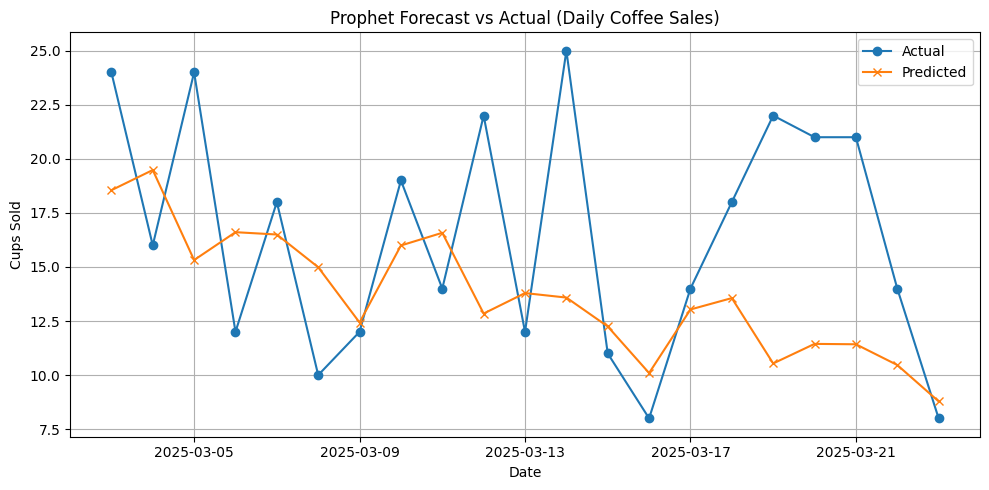

In [ ]:
# Step 1: Log transform
df_general['y'] = np.log1p(df_general['y'])

# Step 2: Split into train/test (last 7 days)
train_df = df_general[:-21]
test_df = df_general[-21:]

# Step 3: Train the model
model = Prophet(
    daily_seasonality=True,         # Now relevant for daily data
    weekly_seasonality=True,
    yearly_seasonality=True
)
model.add_country_holidays(country_name='MY')
model.fit(train_df)

# Step 4: Create future DataFrame for next 2 days
future = model.make_future_dataframe(periods=21, freq='D')

# Step 5: Predict
forecast = model.predict(future)

# Step 6: Inverse transform and clip
forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)

# Step 7: Evaluation on test set
forecast_test = forecast[-21:].copy()
y_true = np.expm1(test_df['y'].values)
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Daily Prophet MAE: {mae:.2f}")
print(f"Daily Prophet RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Step 8: Plot
plt.figure(figsize=(10, 5))
plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
plt.plot(test_df['ds'], y_pred, label='Predicted', marker='x')
plt.title("Prophet Forecast vs Actual (Daily Coffee Sales)")
plt.xlabel("Date")
plt.ylabel("Cups Sold")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Tuning

01:48:36 - cmdstanpy - INFO - Chain [1] start processing


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=1.0


01:48:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=5.0


01:48:39 - cmdstanpy - INFO - Chain [1] start processing
01:48:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=10.0


01:48:41 - cmdstanpy - INFO - Chain [1] start processing
01:48:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=15.0


01:48:44 - cmdstanpy - INFO - Chain [1] start processing
01:48:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=1.0


01:48:47 - cmdstanpy - INFO - Chain [1] start processing
01:48:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=5.0


01:48:50 - cmdstanpy - INFO - Chain [1] start processing
01:48:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=10.0


01:48:53 - cmdstanpy - INFO - Chain [1] start processing
01:48:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=15.0


01:48:56 - cmdstanpy - INFO - Chain [1] start processing
01:48:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=1.0


01:48:58 - cmdstanpy - INFO - Chain [1] start processing
01:48:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=5.0


01:49:01 - cmdstanpy - INFO - Chain [1] start processing
01:49:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=10.0


01:49:04 - cmdstanpy - INFO - Chain [1] start processing
01:49:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=15.0


01:49:07 - cmdstanpy - INFO - Chain [1] start processing
01:49:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=1.0


01:49:10 - cmdstanpy - INFO - Chain [1] start processing
01:49:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=5.0


01:49:13 - cmdstanpy - INFO - Chain [1] start processing
01:49:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=10.0


01:49:16 - cmdstanpy - INFO - Chain [1] start processing
01:49:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=15.0


01:49:19 - cmdstanpy - INFO - Chain [1] start processing
01:49:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Best Parameters:
changepoint_prior_scale     0.050000
seasonality_prior_scale    15.000000
mae                         0.077757
rmse                        0.087998
mape                        0.060923
Name: 7, dtype: float64


01:49:23 - cmdstanpy - INFO - Chain [1] start processing
01:49:23 - cmdstanpy - INFO - Chain [1] done processing



Final Test MAE (best model): 0.36

Final Test RMSE (best model): 0.45

Final Test MAPE (best model): 12.18%


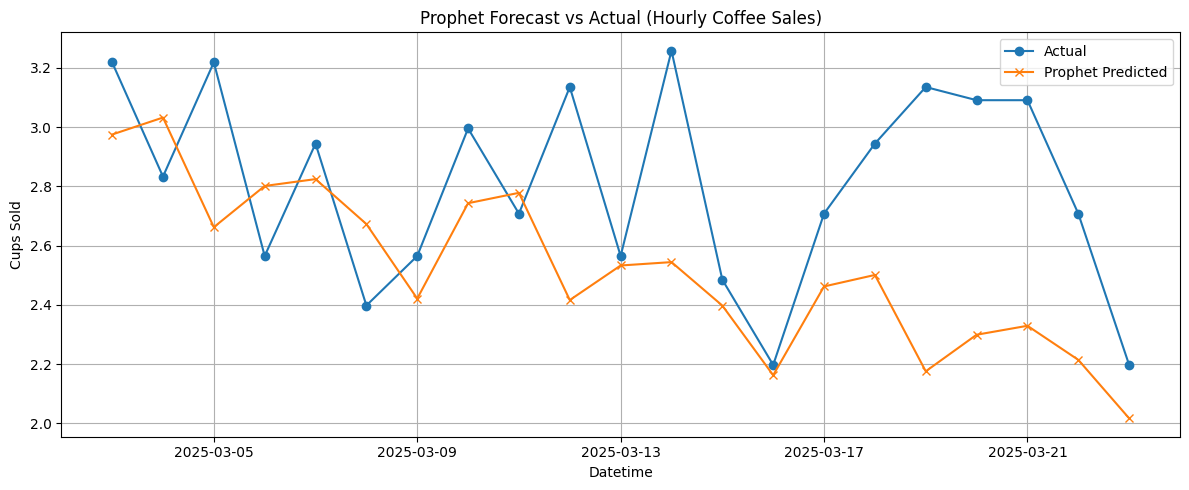

In [ ]:
# Step 0: Log-transform y to stabilize variance
df_general['y'] = np.log1p(df_general['y'])

# Step 1: Split train/test (last 21 days)
train_df = df_general[:-21].copy()
test_df = df_general[-21:].copy()

# Step 2: Define parameter grid
changepoint_range = [0.01, 0.05, 0.1, 0.3]
seasonality_range = [1.0, 5.0, 10.0, 15.0]

results = []

# Step 3: Grid search over parameters
for cp in changepoint_range:
    for sp in seasonality_range:
        print(f"Training: changepoint_prior_scale={cp}, seasonality_prior_scale={sp}")
        m = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True,
            changepoint_prior_scale=cp,
            seasonality_prior_scale=sp
        )
        m.add_country_holidays(country_name='MY')

        m.fit(train_df)

        # Run cross-validation
        df_cv = cross_validation(m, initial='345 days', period='7 days', horizon='21 days', parallel="processes")
        df_p = performance_metrics(df_cv)

        avg_mape = df_p['mape'].mean()
        avg_mae = df_p['mae'].mean()
        avg_rmse = df_p['rmse'].mean()

        results.append({
            'changepoint_prior_scale': cp,
            'seasonality_prior_scale': sp,
            'mae': avg_mae,
            'rmse': avg_rmse,
            'mape': avg_mape
        })

# Step 4: Display best params
results_df = pd.DataFrame(results)
best_params = results_df.sort_values(by='mae').iloc[0]
print("\nBest Parameters:")
print(best_params)

# Step 5: Retrain with best parameters on full training data
best_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)
best_model.add_country_holidays(country_name='MY')
best_model.fit(train_df)

# Step 6: Forecast next 21 days
future = best_model.make_future_dataframe(periods=21, freq='D')
forecast = best_model.predict(future)

# Step 7: Inverse transform and evaluate
forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)
y_true = np.expm1(test_df['y'].values)
y_pred = forecast['yhat'].values[-21:]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"\nFinal Test MAE (best model): {mae:.2f}")
print(f"\nFinal Test RMSE (best model): {rmse:.2f}")
print(f"\nFinal Test MAPE (best model): {mape:.2f}%")

# Step 8: Plot forecast vs actual
plt.figure(figsize=(12, 5))
plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
plt.title("Prophet Forecast vs Actual (Daily Coffee Sales)")
plt.xlabel("Datetime")
plt.ylabel("Cups Sold")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

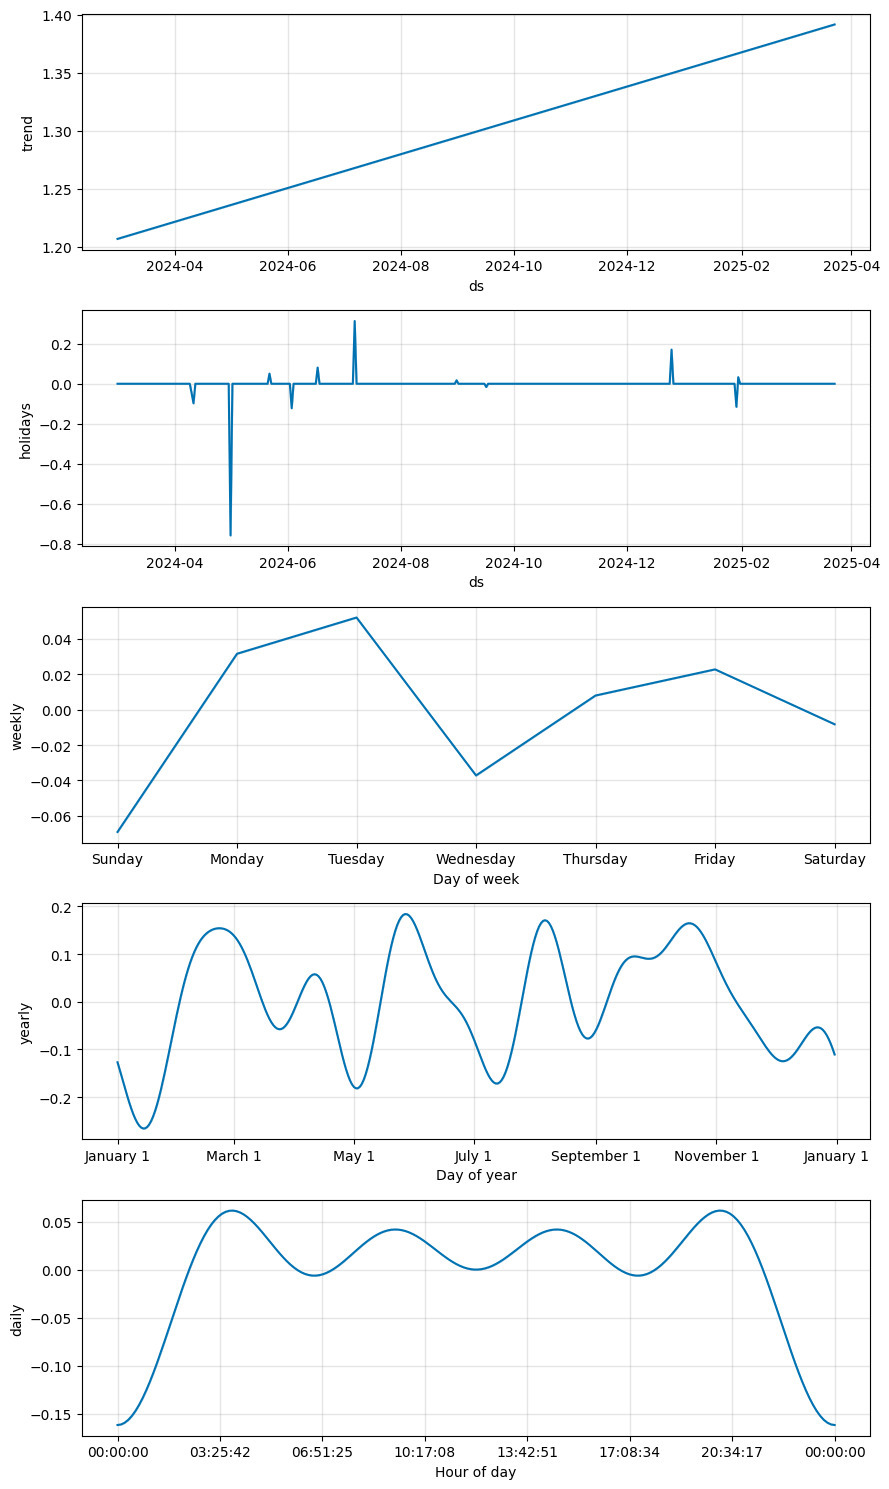

In [13]:
fig = best_model.plot_components(forecast)
plt.tight_layout()
plt.show()

## Specific

In [14]:
def model (coffee_name):
    # Step 1: Prepare data
    df_dailyc = coffee_dfs[coffee_name].rename(columns={'datetime': 'ds', coffee_name: 'y'})

    df_dailyc['y'] = np.log1p(df_dailyc['y'])

    # Step 2: Split into train and test sets
    train_df = df_dailyc[:-21]
    test_df = df_dailyc[-21:]

    # Step 3: Train the model on the training set
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.01,
        seasonality_prior_scale=15.0
    )
    model.add_country_holidays(country_name='MY') 
    model.fit(train_df)

    # Step 4: Create future DataFrame for next 21 days
    future = model.make_future_dataframe(periods=21, freq='D')

    # Step 5: Predict
    forecast = model.predict(future)

    # Step 6: Inverse transform and clip
    forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)
    y_true = np.expm1(test_df['y'].values)
    y_pred = forecast['yhat'].values[-21:]

    # Step 7: Evaluation on test set only
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"Daily Prophet MAE: {mae:.2f}")
    print(f"Daily Prophet RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Step 8: Plot forecast vs actual
    plt.figure(figsize=(12, 5))
    plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
    plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
    plt.title("Prophet Forecast vs Actual (Daily " + coffee_name + " Sales)")
    plt.xlabel("Datetime")
    plt.ylabel("Cups Sold")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()  
    
    fig = best_model.plot_components(forecast)
    plt.tight_layout()
    plt.show()
    

### Americano

01:51:32 - cmdstanpy - INFO - Chain [1] start processing
01:51:32 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 2.98
Daily Prophet RMSE: 3.91
MAPE: 48.93%


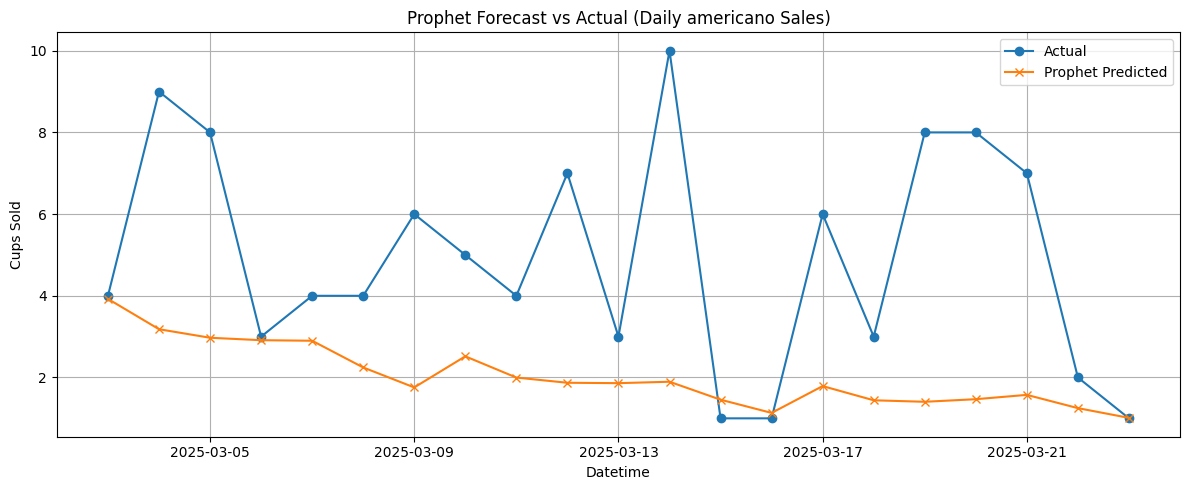

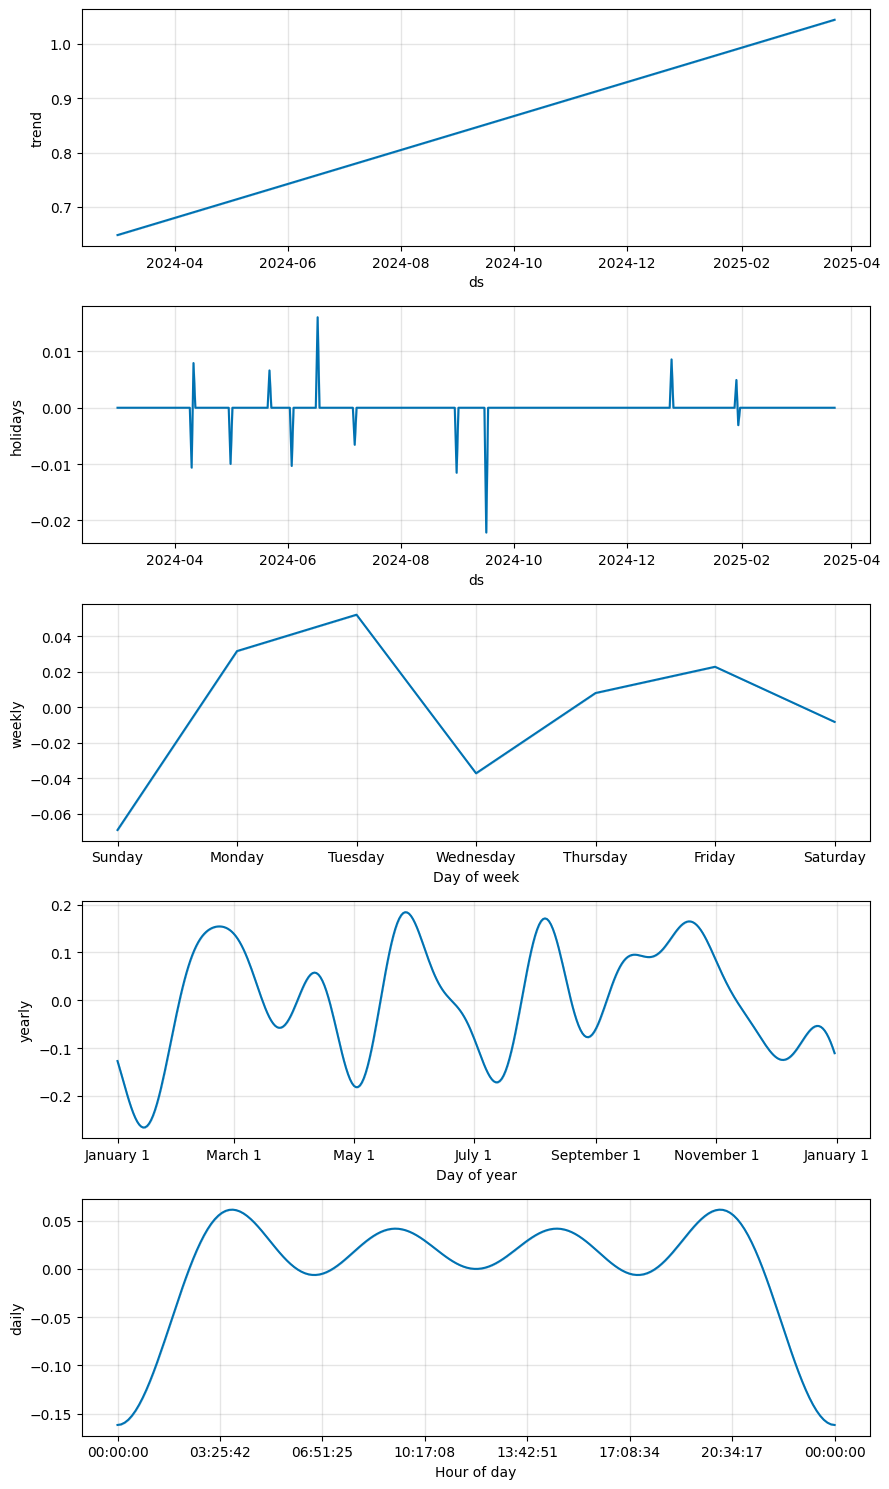

In [15]:
model('americano')  

### Americano with Milk

01:51:36 - cmdstanpy - INFO - Chain [1] start processing
01:51:37 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 2.41
Daily Prophet RMSE: 2.91
MAPE: 71.44%


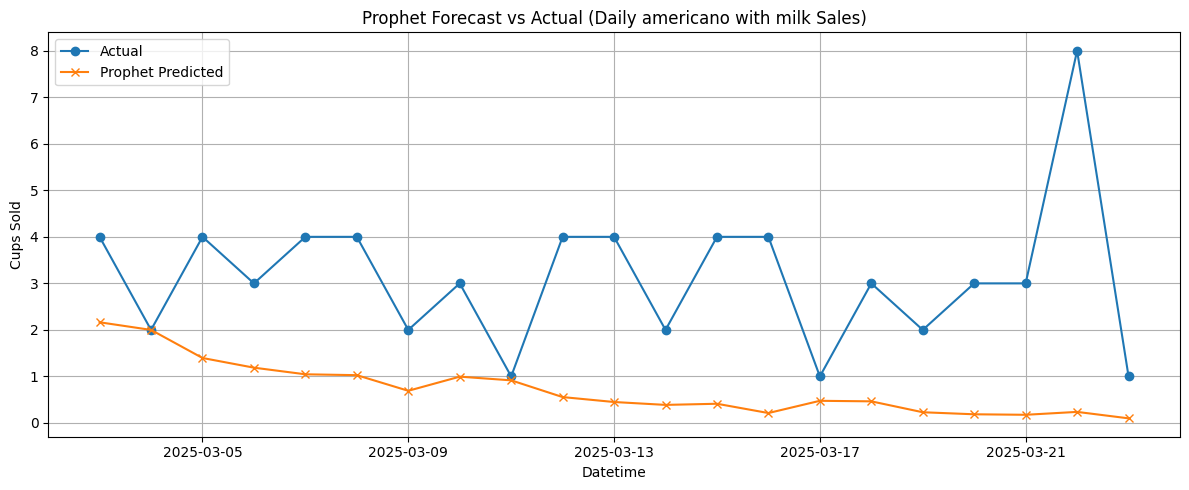

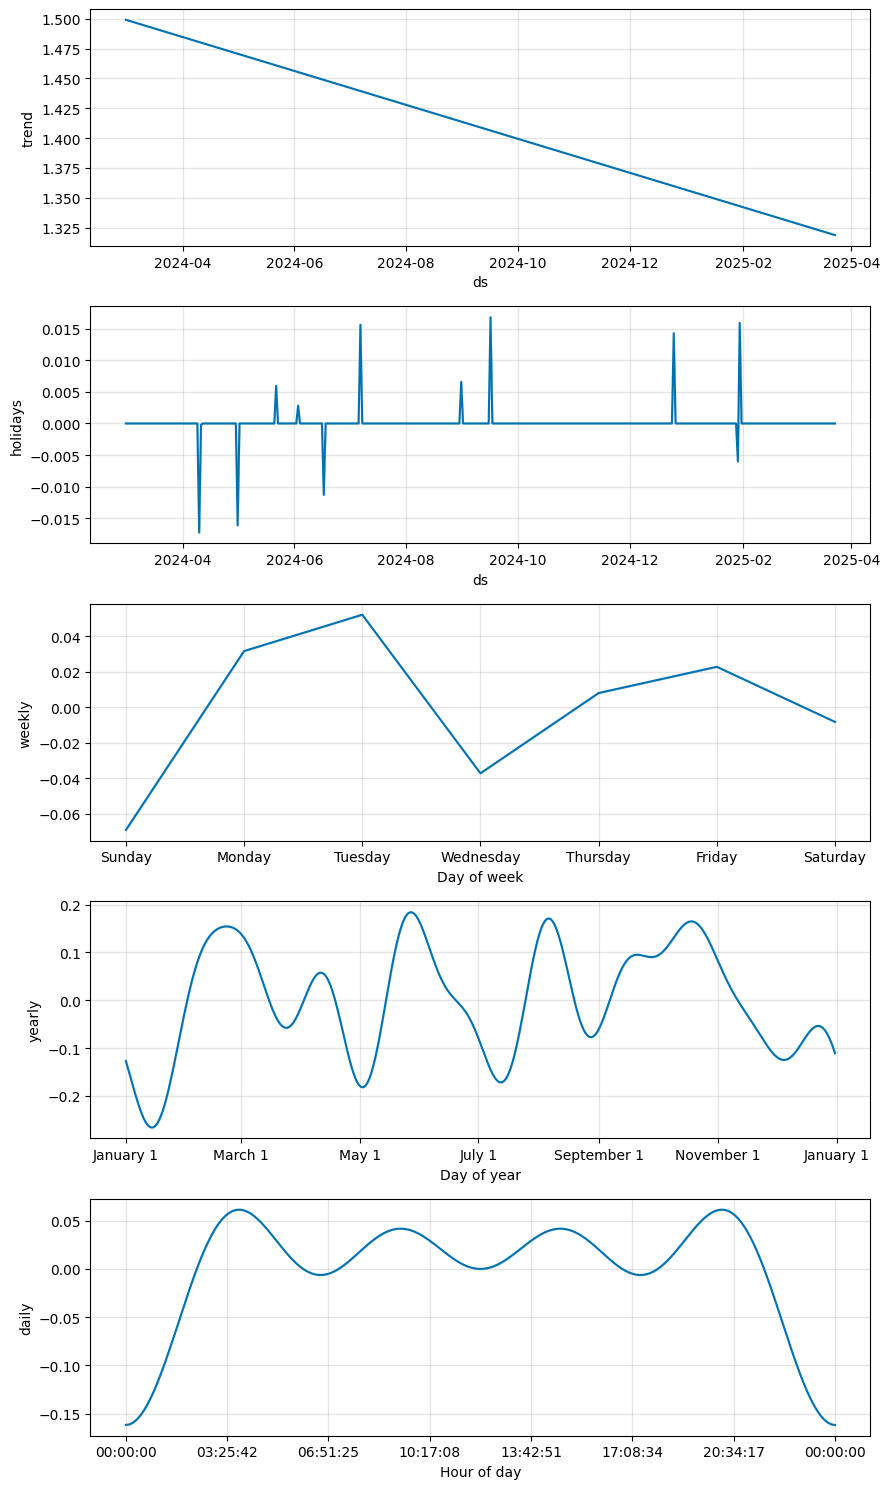

In [16]:
model('americano with milk')  

### Cappuccino

01:51:41 - cmdstanpy - INFO - Chain [1] start processing
01:51:41 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 1.15
Daily Prophet RMSE: 1.34
MAPE: 61.00%


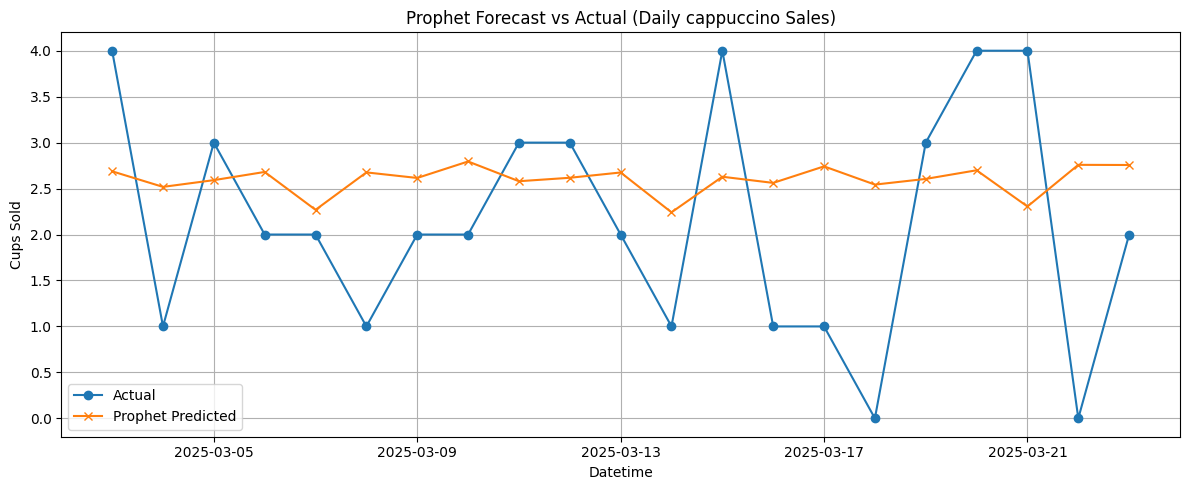

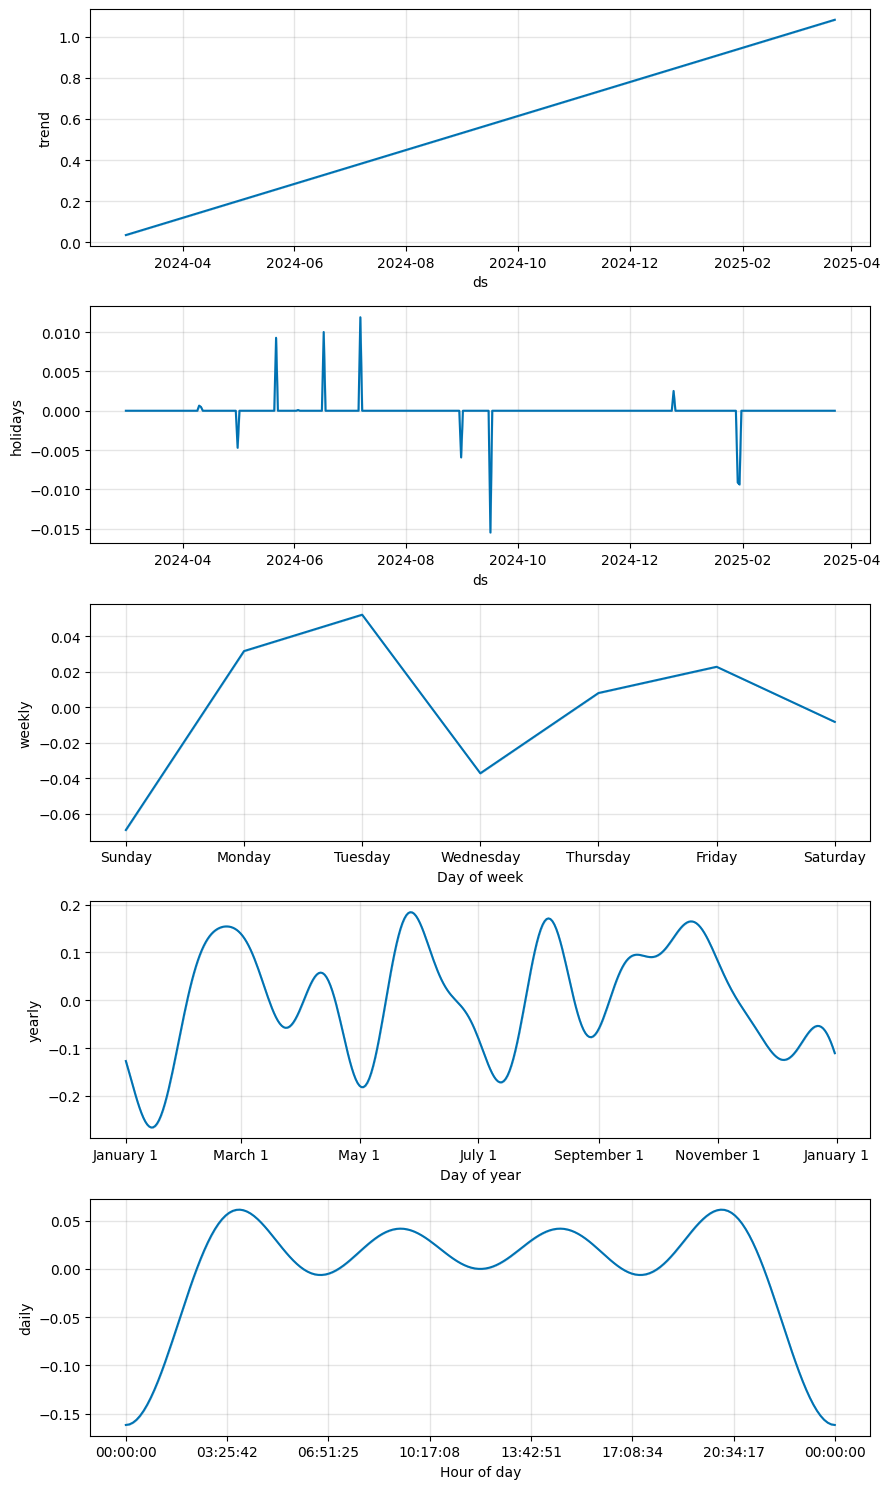

In [17]:
model('cappuccino')  

### Cocoa

01:51:45 - cmdstanpy - INFO - Chain [1] start processing
01:51:45 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 1.21
Daily Prophet RMSE: 1.49
MAPE: 84.63%


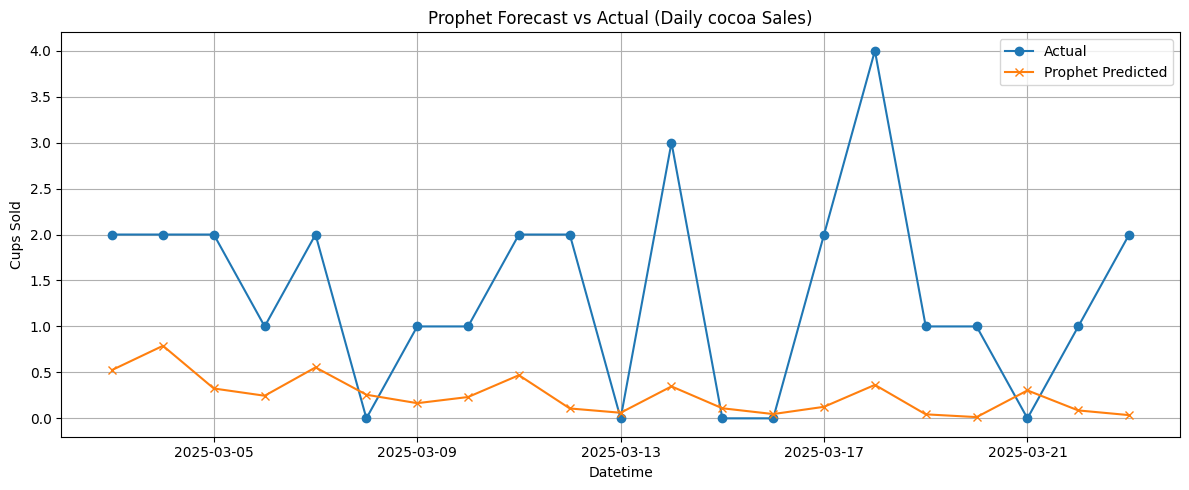

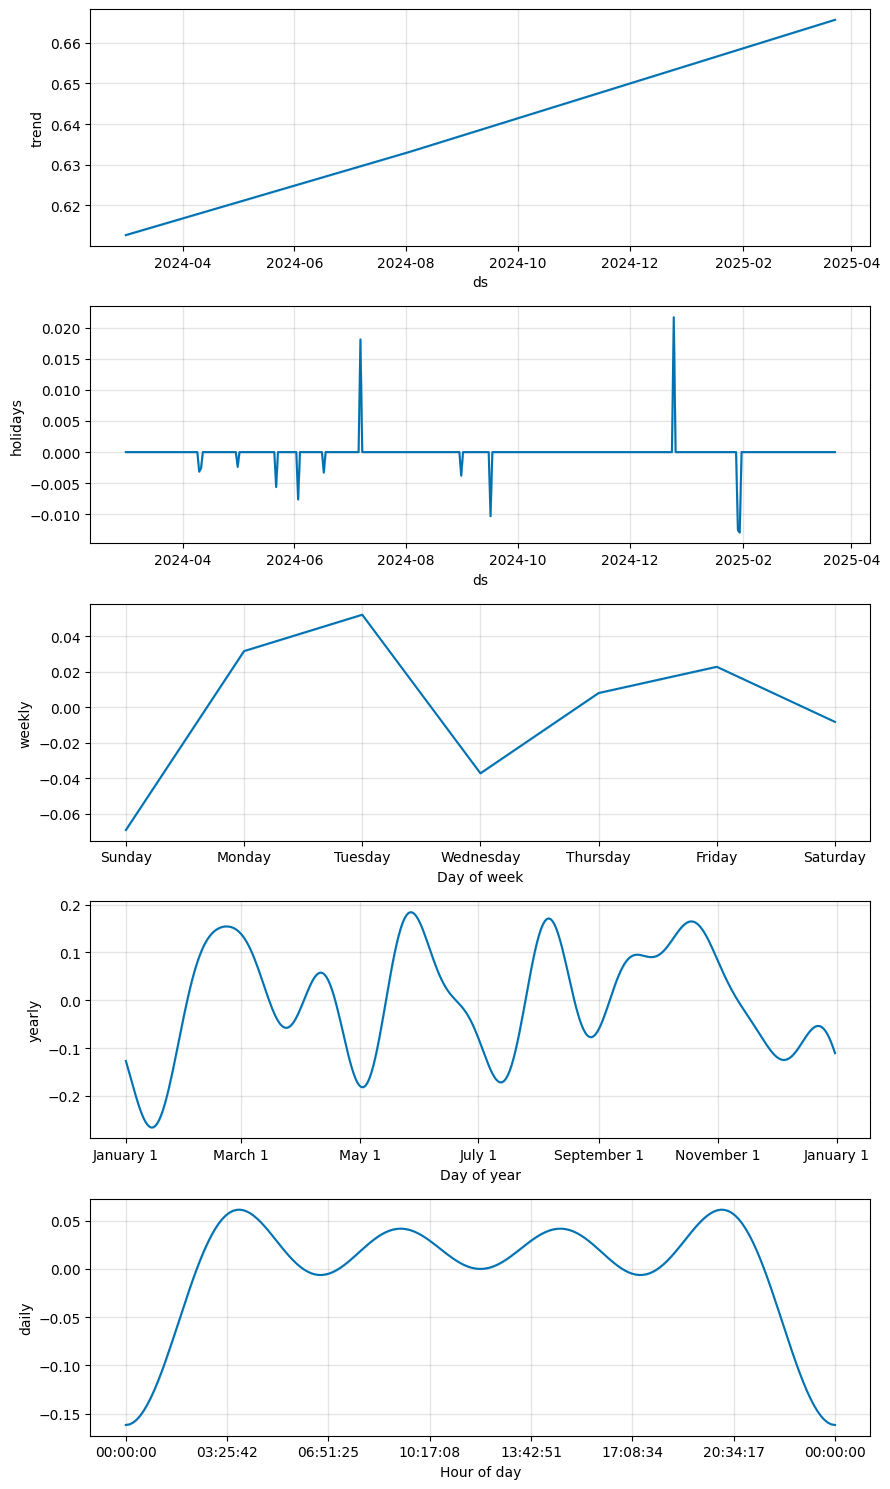

In [18]:
model('cocoa')

### Cortado

01:51:52 - cmdstanpy - INFO - Chain [1] start processing
01:51:52 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 0.80
Daily Prophet RMSE: 0.88
MAPE: 9.17%


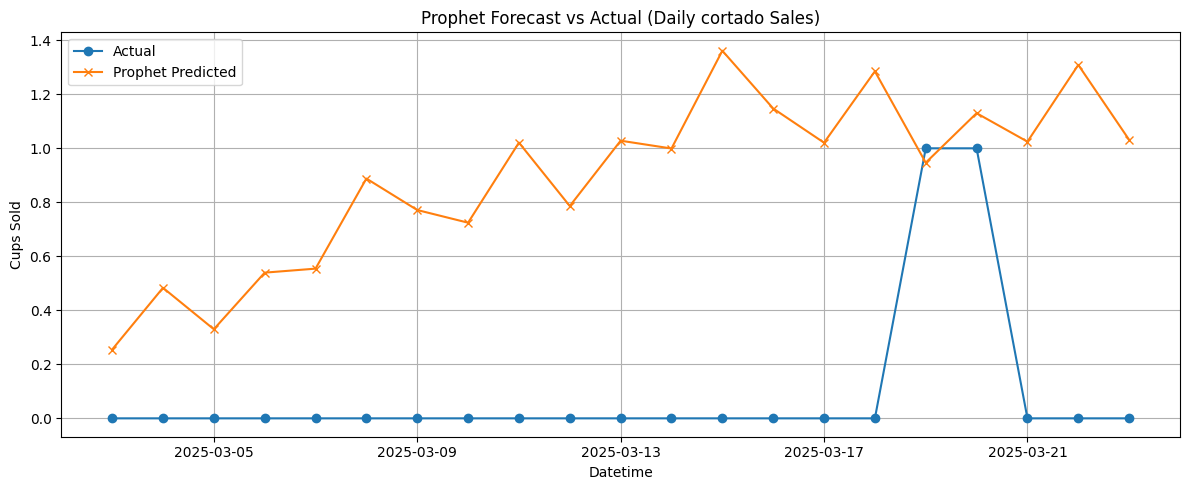

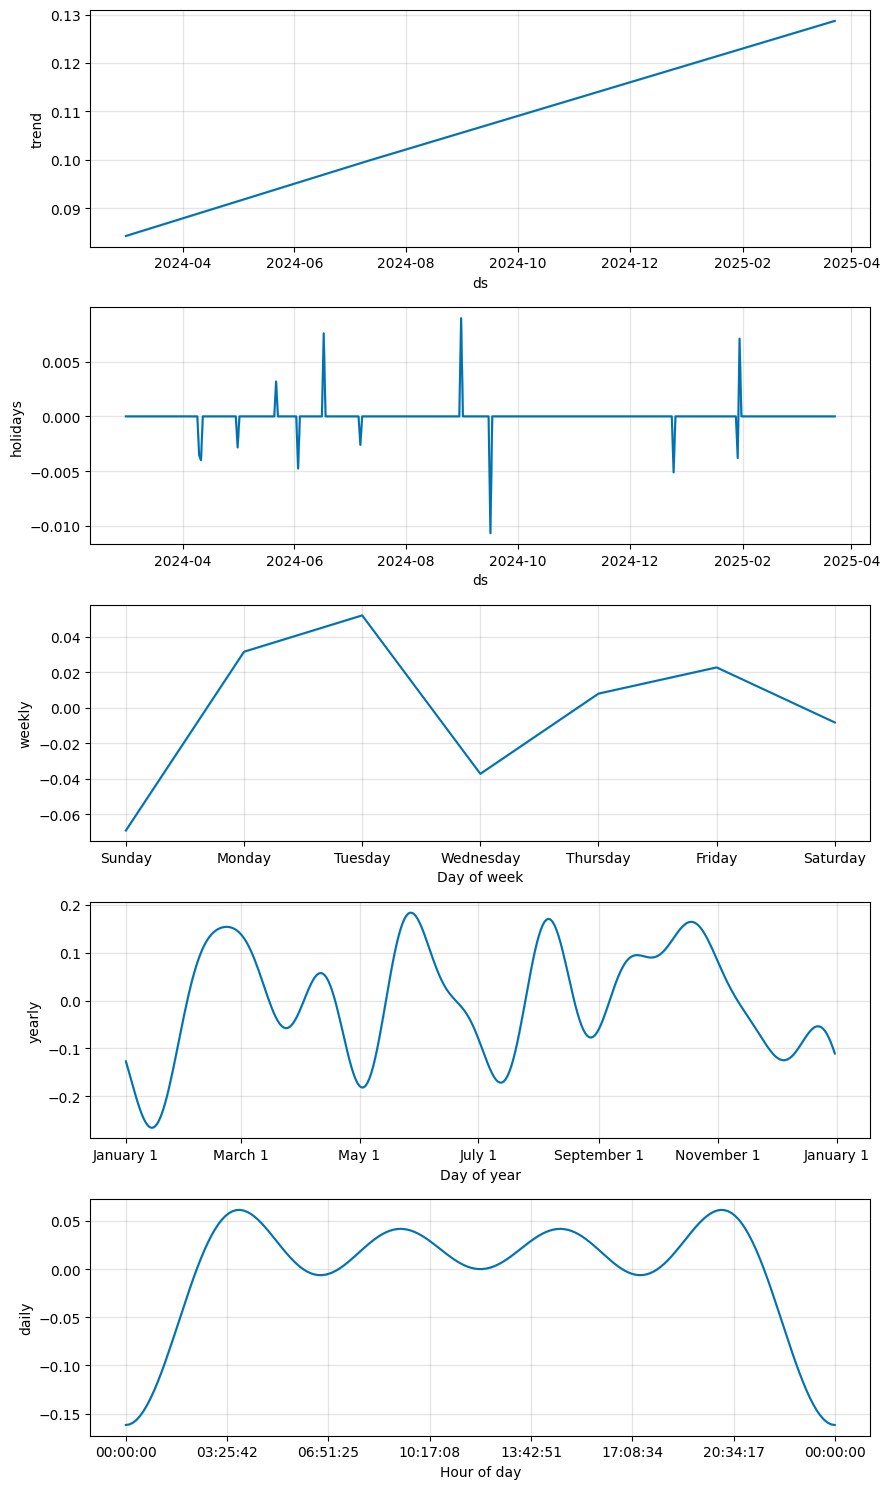

In [19]:
model('cortado')

### Espresso

01:52:02 - cmdstanpy - INFO - Chain [1] start processing
01:52:02 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 0.65
Daily Prophet RMSE: 0.81
MAPE: 75.08%


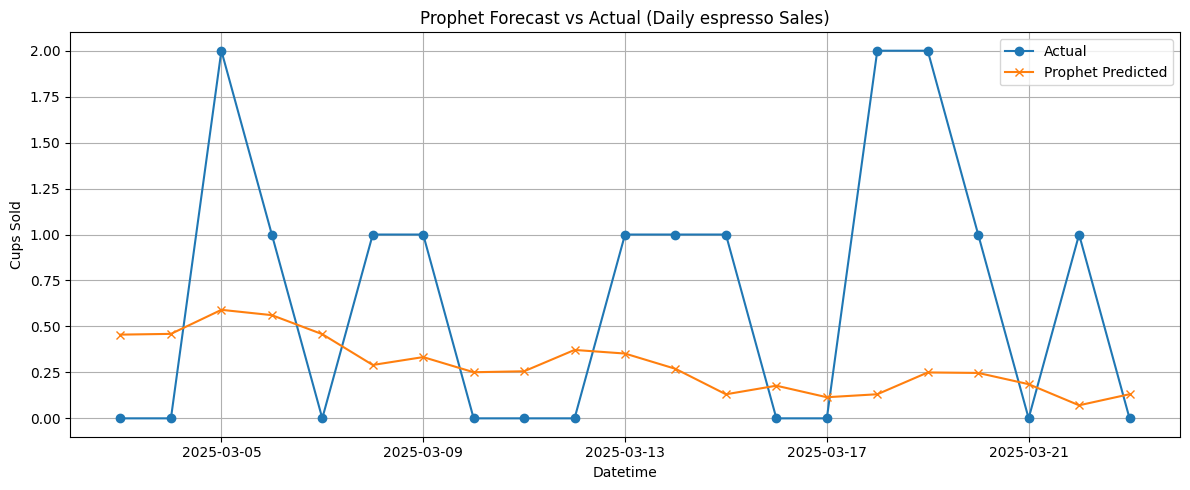

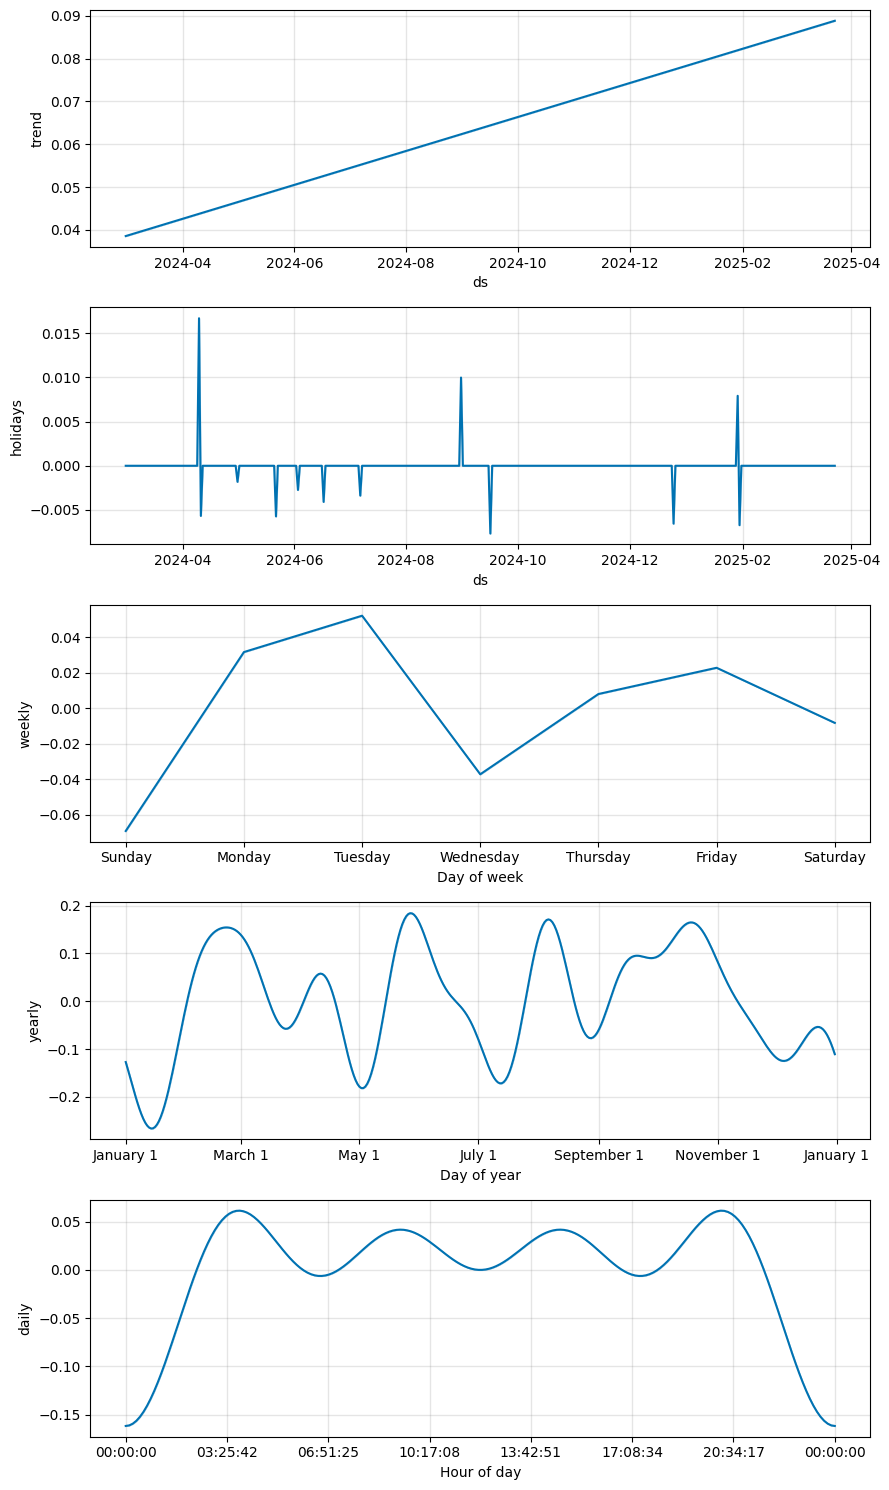

In [20]:
model('espresso')

### Hot Chocolate

01:52:08 - cmdstanpy - INFO - Chain [1] start processing
01:52:08 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 1.10
Daily Prophet RMSE: 1.68
MAPE: 100.00%


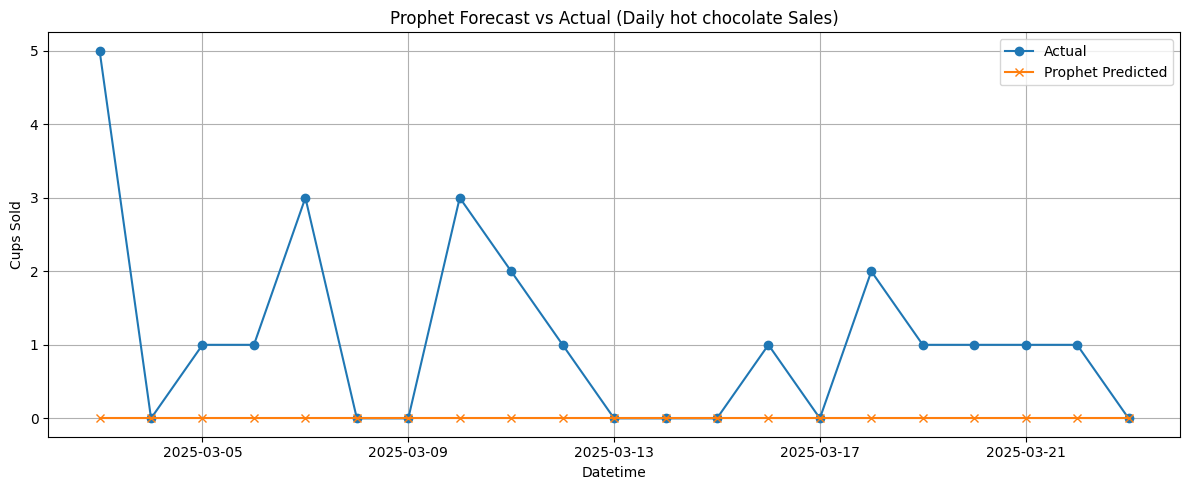

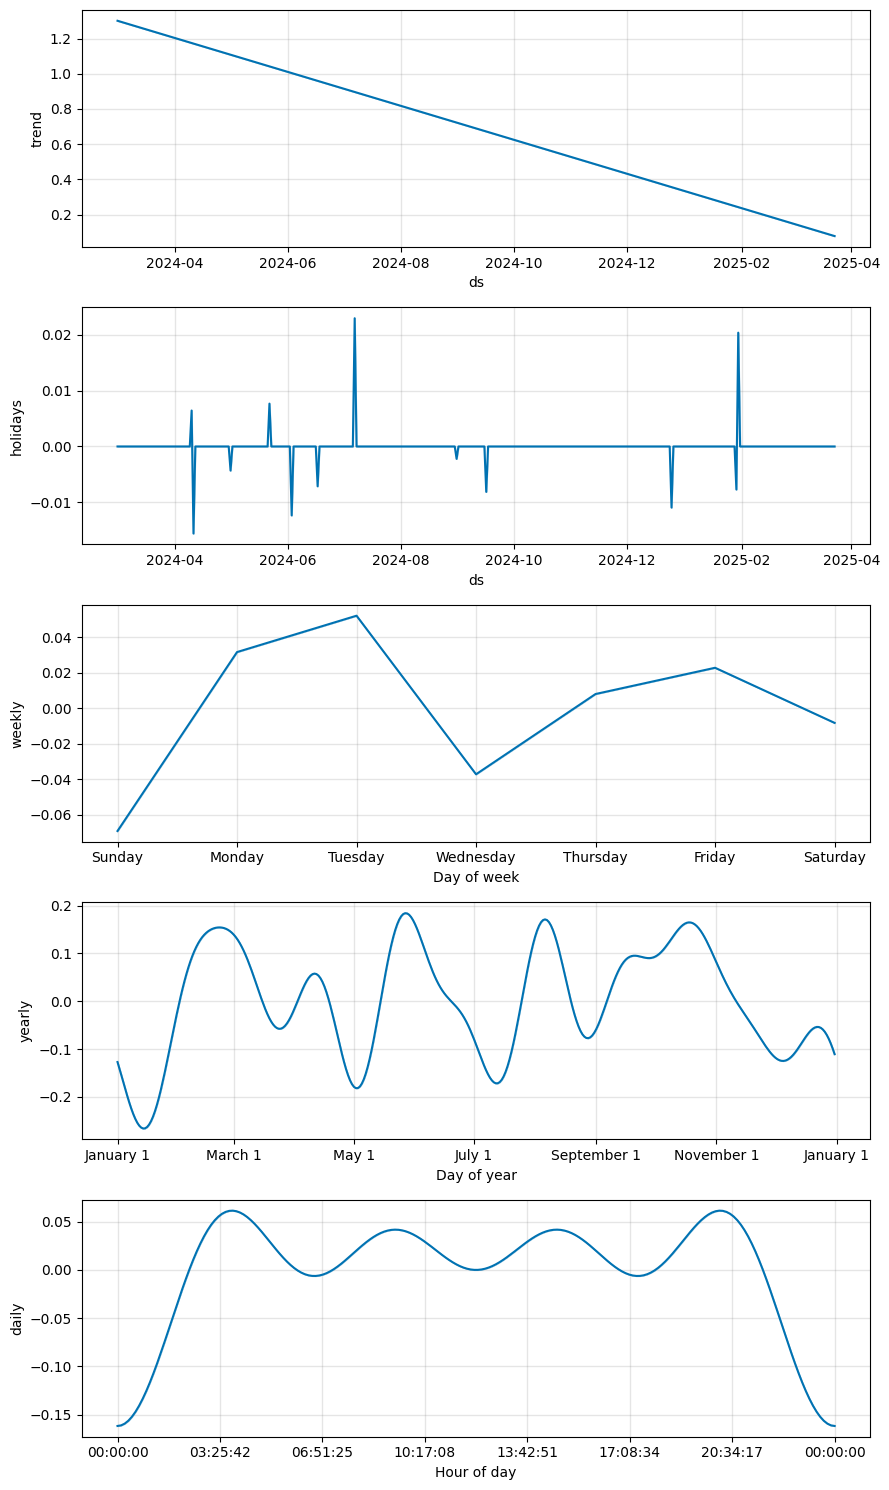

In [21]:
model('hot chocolate')

### Latte

01:52:19 - cmdstanpy - INFO - Chain [1] start processing
01:52:19 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 1.85
Daily Prophet RMSE: 2.50
MAPE: 47.47%


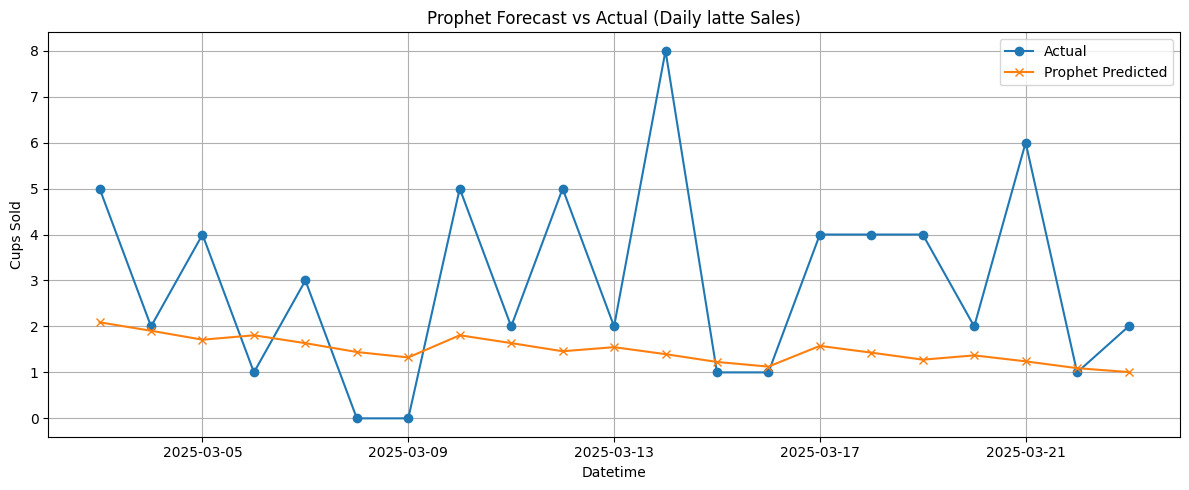

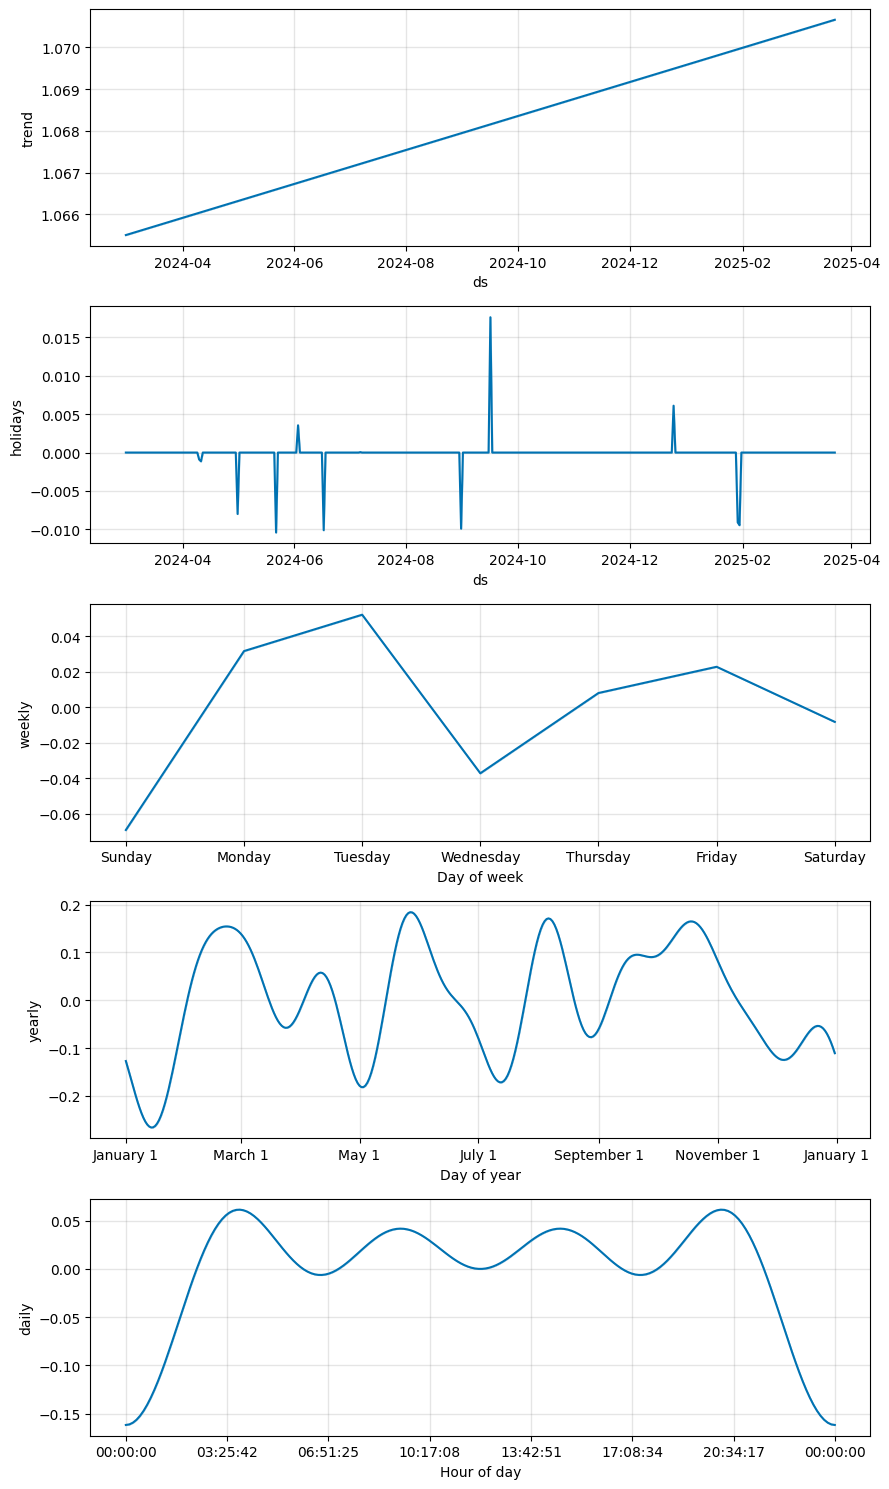

In [22]:
model('latte')

# By Sales

In [24]:
df_s = pd.read_csv('Dataset/top9_coffee_revenue_by_column.csv')

In [25]:
df_s['datetime'] = pd.to_datetime(df_s['datetime'])

In [26]:
df_s.head()

datetime  americano  americano with milk  cappuccino  cocoa  \
0 2024-03-01 10:15:00        0.0                  0.0         0.0    0.0   
1 2024-03-01 12:19:00        0.0                  0.0         0.0    0.0   
2 2024-03-01 12:20:00        0.0                  0.0         0.0    0.0   
3 2024-03-01 13:46:00       28.9                  0.0         0.0    0.0   
4 2024-03-01 13:48:00        0.0                  0.0         0.0    0.0   

   cortado  espresso  hot chocolate  irish whiskey  latte  
0      0.0       0.0            0.0              0   38.7  
1      0.0       0.0           38.7              0    0.0  
2      0.0       0.0           38.7              0    0.0  
3      0.0       0.0            0.0              0    0.0  
4      0.0       0.0            0.0              0   38.7

In [27]:
df_s = df_s.resample('D', on='datetime').sum().reset_index()

In [28]:
df_s.head()

datetime  americano  americano with milk  cappuccino  cocoa  cortado  \
0 2024-03-01       28.9                135.2         0.0   38.7      0.0   
1 2024-03-02       86.7                101.4         0.0    0.0      0.0   
2 2024-03-03       28.9                 67.6         0.0   38.7     57.8   
3 2024-03-04        0.0                 33.8         0.0    0.0      0.0   
4 2024-03-05        0.0                  0.0         0.0   38.7     28.9   

   espresso  hot chocolate  irish whiskey  latte  
0       0.0          116.1              0   77.4  
1       0.0            0.0              0   40.0  
2       0.0           77.4              0   78.7  
3      24.0            0.0              0   77.4  
4       0.0          154.8              0  116.1

In [29]:
# List of coffee types (excluding datetime)
coffee_types_s = ['americano', 'americano with milk', 'cappuccino', 'cocoa', 'cortado',
                'espresso', 'hot chocolate', 'irish whiskey', 'latte']

# Dictionary to store the individual DataFrames
coffee_df_s = {}

# Create one DataFrame per coffee type
for coffee in coffee_types_s:
    coffee_df_s[coffee] = df_s[['datetime', coffee]].copy()

In [30]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

## General

In [31]:
df_general_s = df_s.copy()
df_general_s['y'] = df_general_s[coffee_types_s].sum(axis=1)

In [32]:
df_general_s = df_general_s.rename(columns={'datetime': 'ds', 'y': 'y'})
df_general_s = df_general_s[['ds', 'y']]

01:54:17 - cmdstanpy - INFO - Chain [1] start processing
01:54:18 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 187.48
Daily Prophet RMSE: 231.56
MAPE: 32.46%


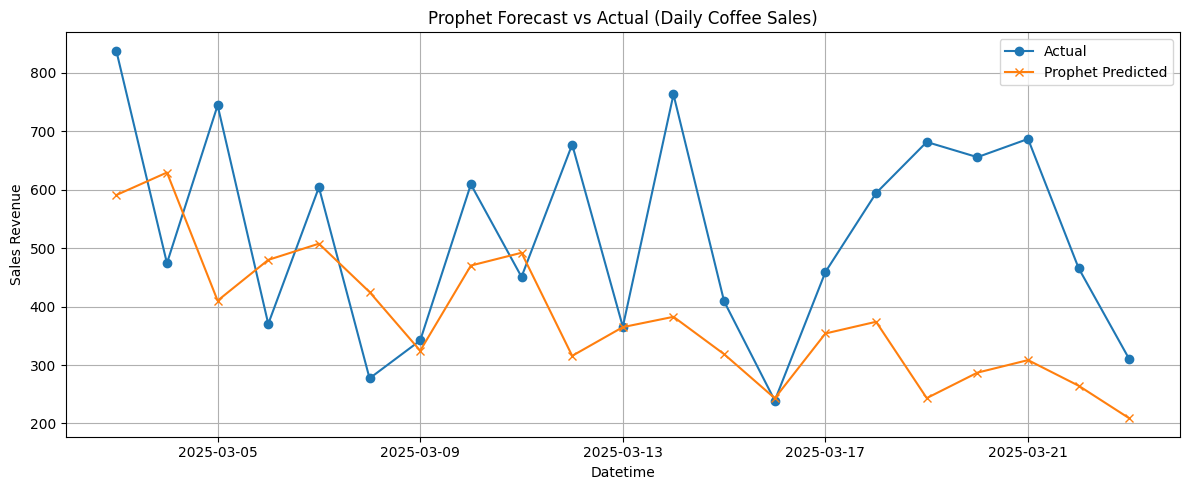

In [33]:
df_general_s['y'] = np.log1p(df_general_s['y'])

# Step 1: Split into train and test sets
train_df = df_general_s[:-21]
test_df = df_general_s[-21:]

# Step 2: Train the model on the training set
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True 
)
model.add_country_holidays(country_name='MY') 
model.fit(train_df)

# Step 4: Create future DataFrame for next 21 days
future = model.make_future_dataframe(periods=21, freq='D')

# Step 5: Predict
forecast = model.predict(future)

# Step 6: Inverse transform and clip
forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)

# Step 7: Evaluation on test set only
forecast_test = forecast[-21:].copy()
y_true = np.expm1(test_df['y'].values)
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Daily Prophet MAE: {mae:.2f}")
print(f"Daily Prophet RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Step 8: Plot forecast vs actual
plt.figure(figsize=(12, 5))
plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
plt.title("Prophet Forecast vs Actual (Daily Coffee Sales)")
plt.xlabel("Datetime")
plt.ylabel("Sales Revenue")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()  

### Tuning

01:55:39 - cmdstanpy - INFO - Chain [1] start processing


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=1.0


01:55:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=5.0


01:55:44 - cmdstanpy - INFO - Chain [1] start processing
01:55:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
01:55:46 - cmdstanpy - INFO - Chain [1] start processing


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=10.0


01:55:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
01:55:48 - cmdstanpy - INFO - Chain [1] start processing


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=15.0


01:55:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=1.0


01:55:50 - cmdstanpy - INFO - Chain [1] start processing
01:55:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=5.0


01:55:54 - cmdstanpy - INFO - Chain [1] start processing
01:55:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=10.0


01:55:57 - cmdstanpy - INFO - Chain [1] start processing
01:55:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=15.0


01:55:59 - cmdstanpy - INFO - Chain [1] start processing
01:55:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=1.0


01:56:02 - cmdstanpy - INFO - Chain [1] start processing
01:56:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=5.0


01:56:04 - cmdstanpy - INFO - Chain [1] start processing
01:56:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=10.0


01:56:07 - cmdstanpy - INFO - Chain [1] start processing
01:56:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=15.0


01:56:10 - cmdstanpy - INFO - Chain [1] start processing
01:56:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=1.0


01:56:12 - cmdstanpy - INFO - Chain [1] start processing
01:56:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=5.0


01:56:15 - cmdstanpy - INFO - Chain [1] start processing
01:56:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=10.0


01:56:17 - cmdstanpy - INFO - Chain [1] start processing
01:56:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=15.0


01:56:20 - cmdstanpy - INFO - Chain [1] start processing
01:56:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Best Parameters:
changepoint_prior_scale    0.010000
seasonality_prior_scale    5.000000
mae                        0.063423
rmse                       0.070312
mape                       0.031927
Name: 1, dtype: float64


01:56:23 - cmdstanpy - INFO - Chain [1] start processing
01:56:23 - cmdstanpy - INFO - Chain [1] done processing



Final Test MAE (best model): 1.00

Final Test RMSE (best model): 1.15

Final Test MAPE (best model): 15.94%


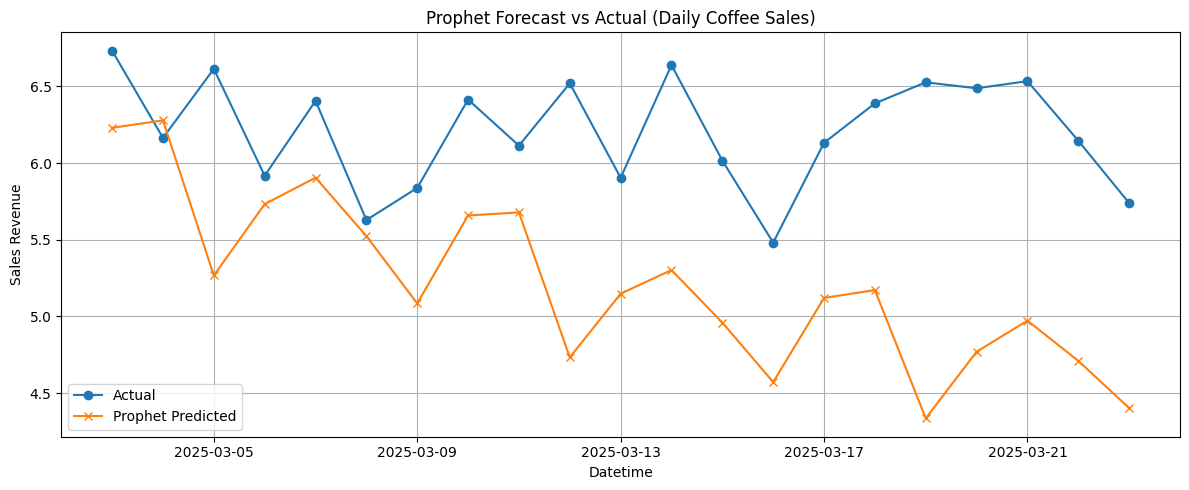

In [34]:
# Step 0: Log-transform y to stabilize variance
df_general_s['y'] = np.log1p(df_general_s['y'])

# Step 1: Split train/test (last 21 days)
train_df = df_general_s[:-21].copy()
test_df = df_general_s[-21:].copy()

# Step 2: Define parameter grid
changepoint_range = [0.01, 0.05, 0.1, 0.3]
seasonality_range = [1.0, 5.0, 10.0, 15.0]

results = []

# Step 3: Grid search over parameters
for cp in changepoint_range:
    for sp in seasonality_range:
        print(f"Training: changepoint_prior_scale={cp}, seasonality_prior_scale={sp}")
        m = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True,
            changepoint_prior_scale=cp,
            seasonality_prior_scale=sp
        )
        m.add_country_holidays(country_name='MY')

        m.fit(train_df)

        # Run cross-validation
        df_cv = cross_validation(m, initial='345 days', period='7 days', horizon='21 days', parallel="processes")
        df_p = performance_metrics(df_cv)

        avg_mape = df_p['mape'].mean()
        avg_mae = df_p['mae'].mean()
        avg_rmse = df_p['rmse'].mean()

        results.append({
            'changepoint_prior_scale': cp,
            'seasonality_prior_scale': sp,
            'mae': avg_mae,
            'rmse': avg_rmse,
            'mape': avg_mape
        })

# Step 4: Display best params
results_df = pd.DataFrame(results)
best_params = results_df.sort_values(by='mae').iloc[0]
print("\nBest Parameters:")
print(best_params)

# Step 5: Retrain with best parameters on full training data
best_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)
best_model.add_country_holidays(country_name='MY')
best_model.fit(train_df)

# Step 6: Forecast next 21 days
future = best_model.make_future_dataframe(periods=21, freq='D')
forecast = best_model.predict(future)

# Step 7: Inverse transform and evaluate
forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)
y_true = np.expm1(test_df['y'].values)
y_pred = forecast['yhat'].values[-21:]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"\nFinal Test MAE (best model): {mae:.2f}")
print(f"\nFinal Test RMSE (best model): {rmse:.2f}")
print(f"\nFinal Test MAPE (best model): {mape:.2f}%")

# Step 8: Plot forecast vs actual
plt.figure(figsize=(12, 5))
plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
plt.title("Prophet Forecast vs Actual (Daily Coffee Sales)")
plt.xlabel("Datetime")
plt.ylabel("Sales Revenue")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

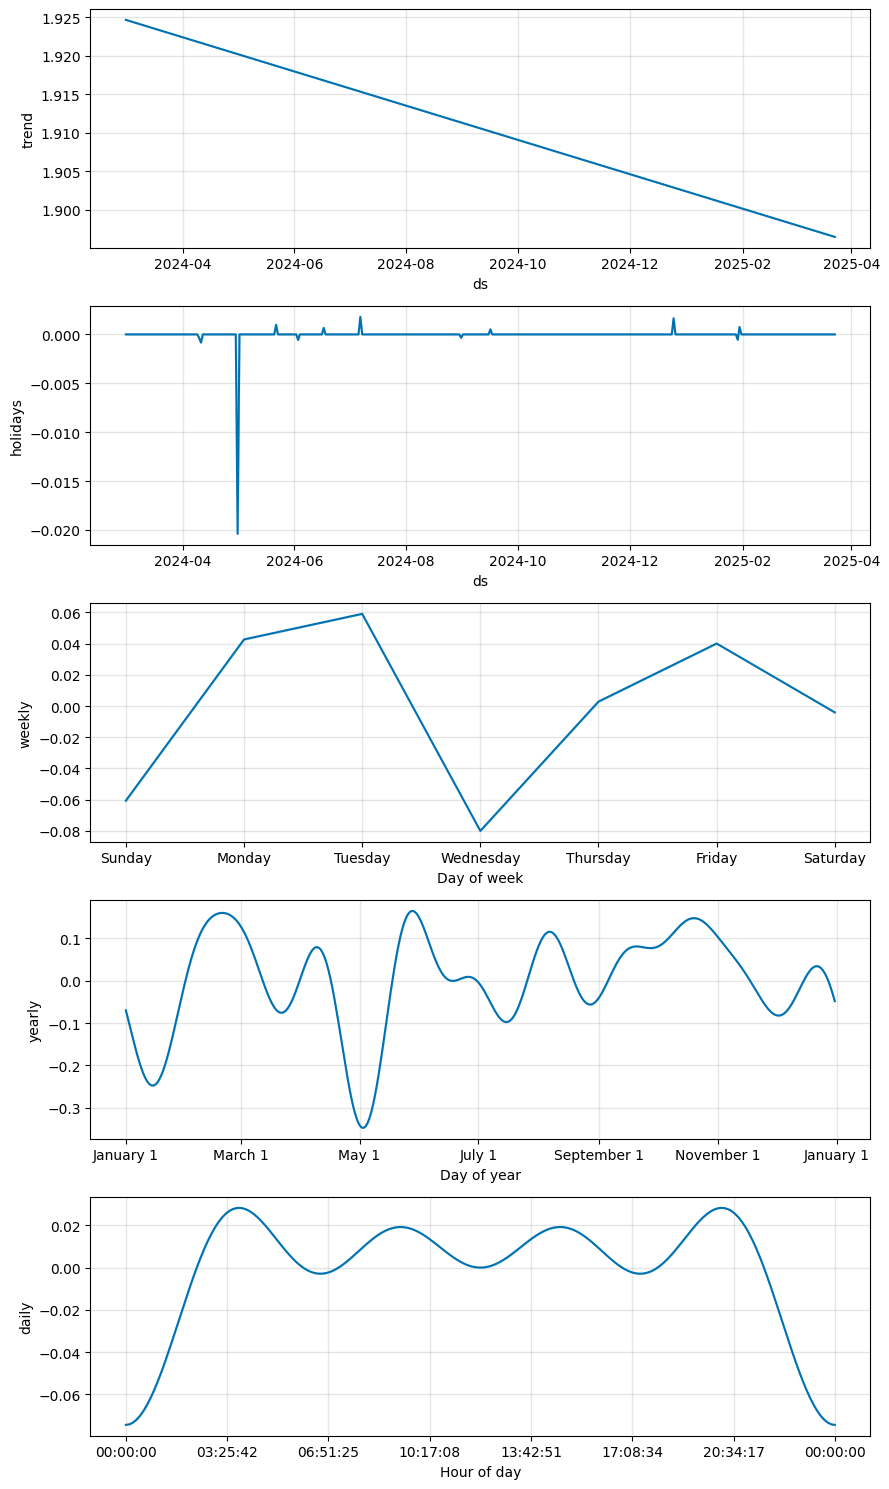

In [35]:
fig = best_model.plot_components(forecast)
plt.tight_layout()
plt.show()

## Specific

In [36]:
def model_s (coffee_name):
    # Step 1: Prepare data
    df_dailys = coffee_df_s[coffee_name].rename(columns={'datetime': 'ds', coffee_name: 'y'})

    df_dailys['y'] = np.log1p(df_dailys['y'])

    # Step 2: Split into train and test sets
    train_df = df_dailys[:-21]
    test_df = df_dailys[-21:]

    # Step 3: Train the model on the training set
    model = Prophet(
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.01,
        seasonality_prior_scale=5.0
    )
    model.add_country_holidays(country_name='MY') 
    model.fit(train_df)

    # Step 4: Create future DataFrame for next 21 days
    future = model.make_future_dataframe(periods=21, freq='D')

    # Step 5: Predict
    forecast = model.predict(future)

    # Step 6: Inverse transform and clip
    forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)
    y_true = np.expm1(test_df['y'].values)
    y_pred = forecast['yhat'].values[-21:]

    # Step 7: Evaluation on test set only
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"Daily Prophet MAE: {mae:.2f}")
    print(f"Daily Prophet RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Step 8: Plot forecast vs actual
    plt.figure(figsize=(12, 5))
    plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
    plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
    plt.title("Prophet Forecast vs Actual (Daily " + coffee_name + " Sales)")
    plt.xlabel("Datetime")
    plt.ylabel("Sales Revenue")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()  
    
    fig = best_model.plot_components(forecast)
    plt.tight_layout()
    plt.show()
    

### Americano

01:58:43 - cmdstanpy - INFO - Chain [1] start processing
01:58:43 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 96.01
Daily Prophet RMSE: 118.48
MAPE: 68.30%


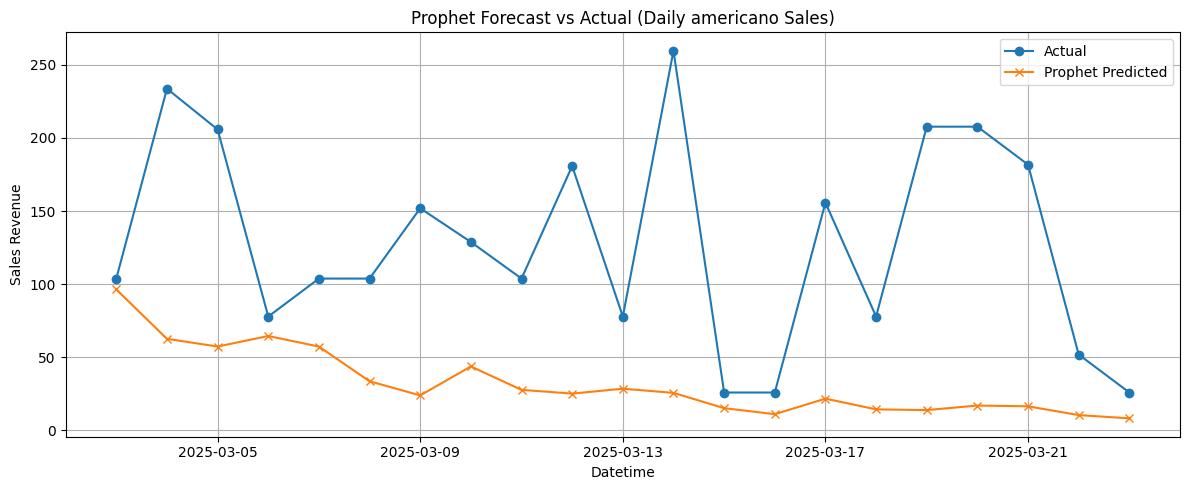

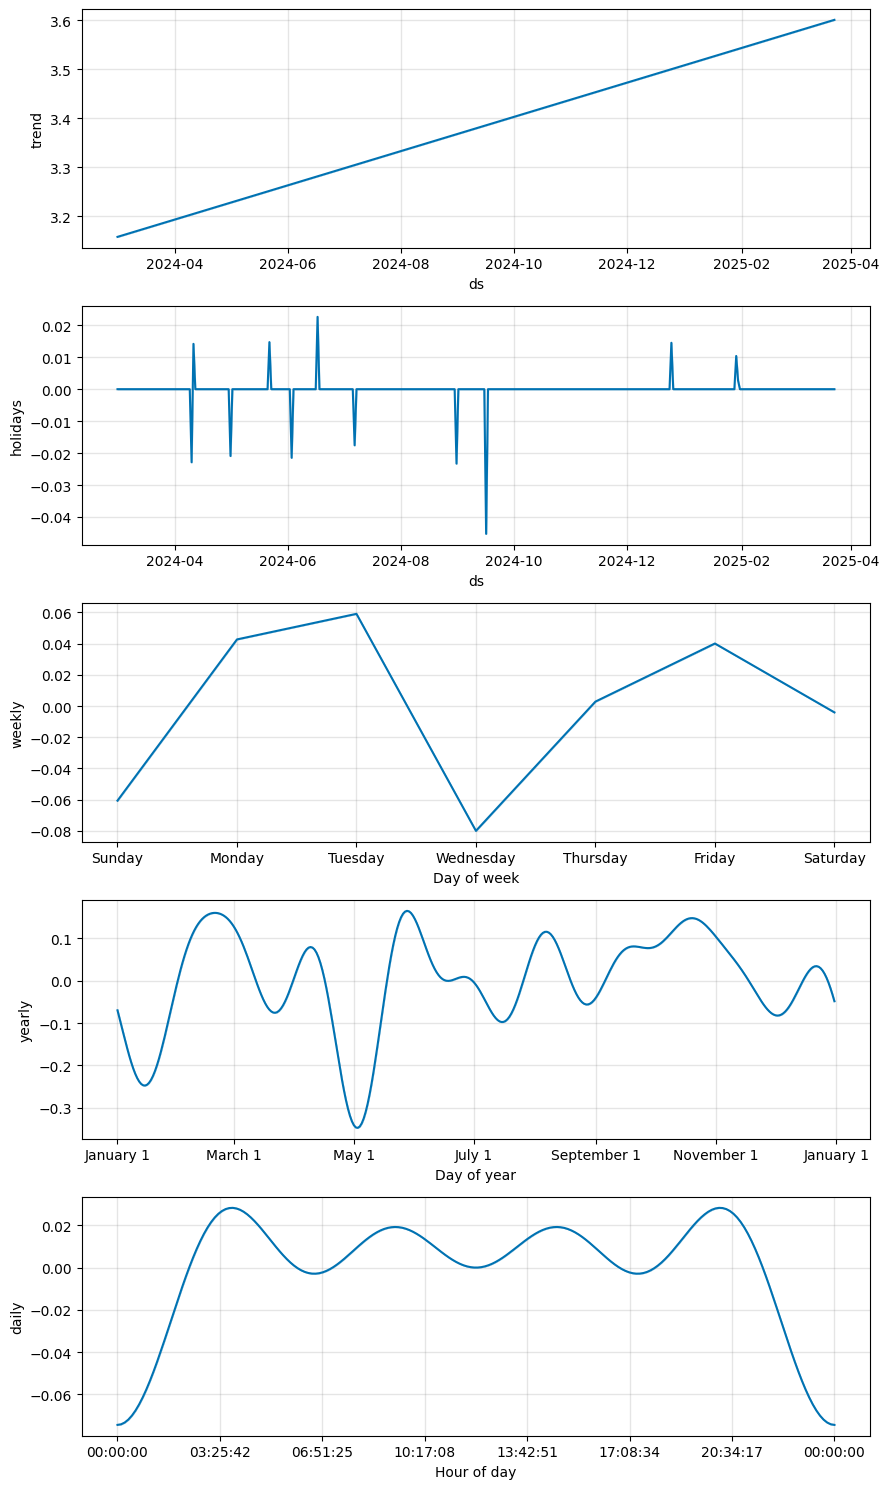

In [37]:
model_s('americano')  

### Americano with Milk

01:59:56 - cmdstanpy - INFO - Chain [1] start processing
01:59:56 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 77.77
Daily Prophet RMSE: 90.52
MAPE: 81.70%


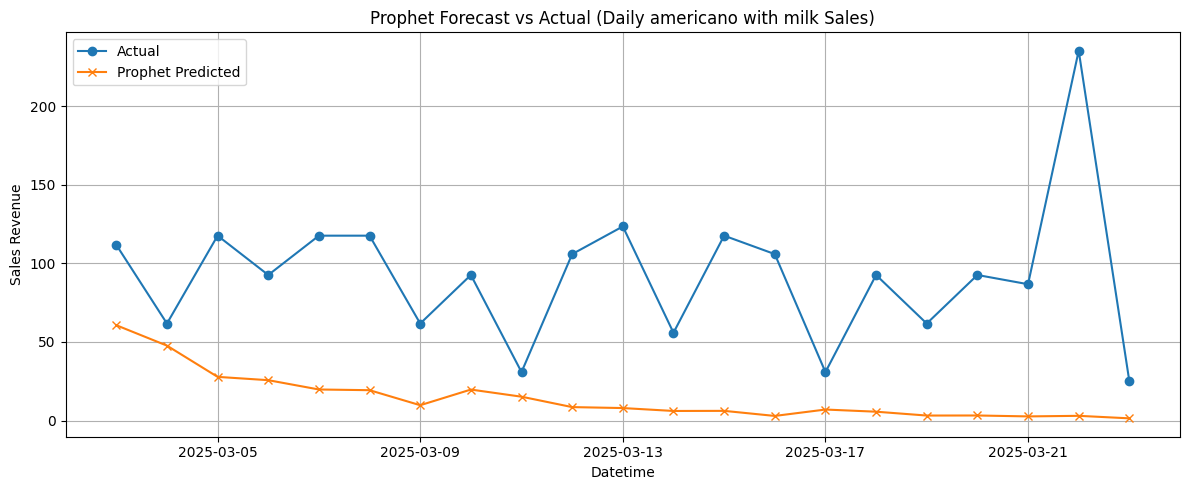

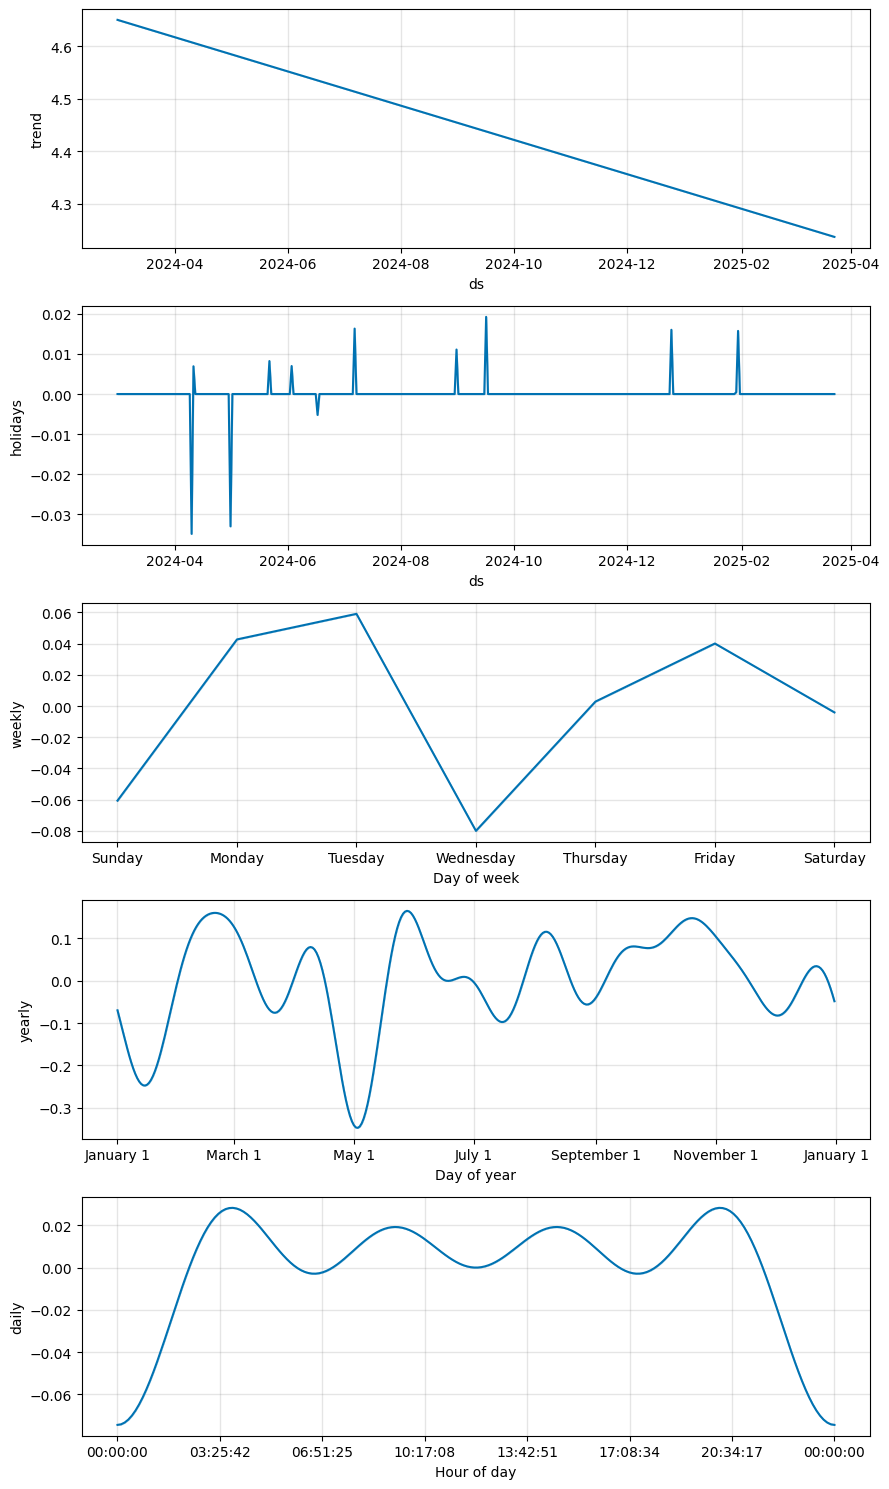

In [38]:
model_s('americano with milk')

### Cappuccino

02:00:33 - cmdstanpy - INFO - Chain [1] start processing
02:00:33 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 87.52
Daily Prophet RMSE: 109.16
MAPE: 135.07%


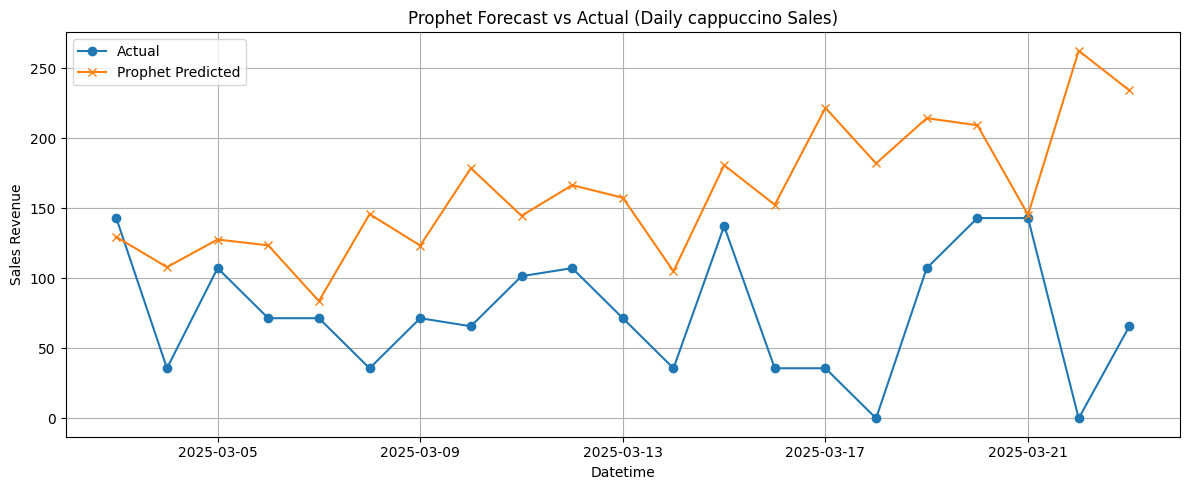

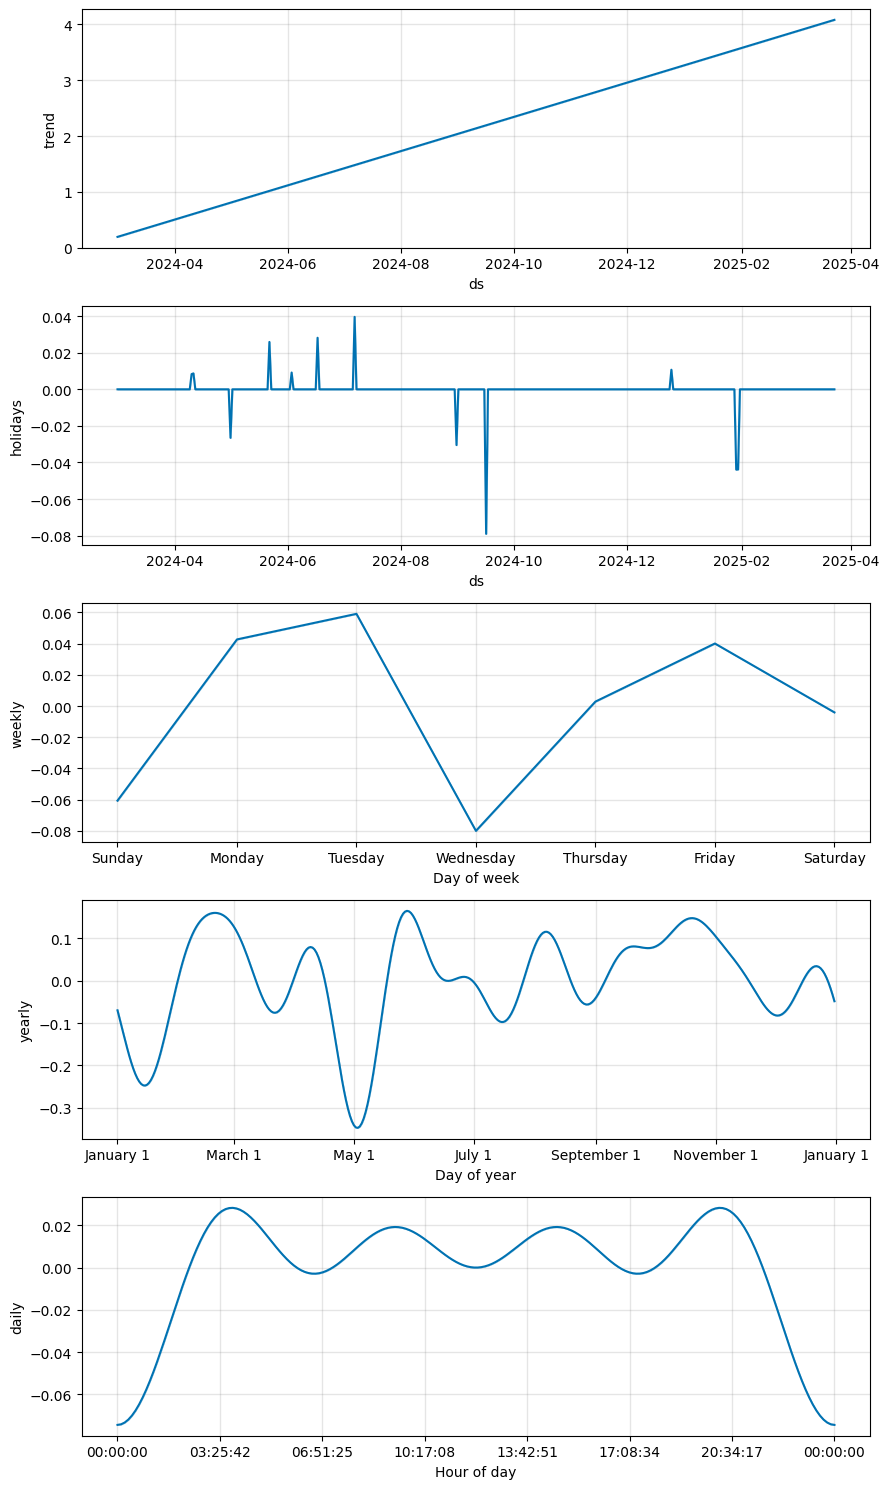

In [39]:
model_s('cappuccino')

### Cocoa

02:00:58 - cmdstanpy - INFO - Chain [1] start processing
02:00:59 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 47.77
Daily Prophet RMSE: 59.81
MAPE: 96.34%


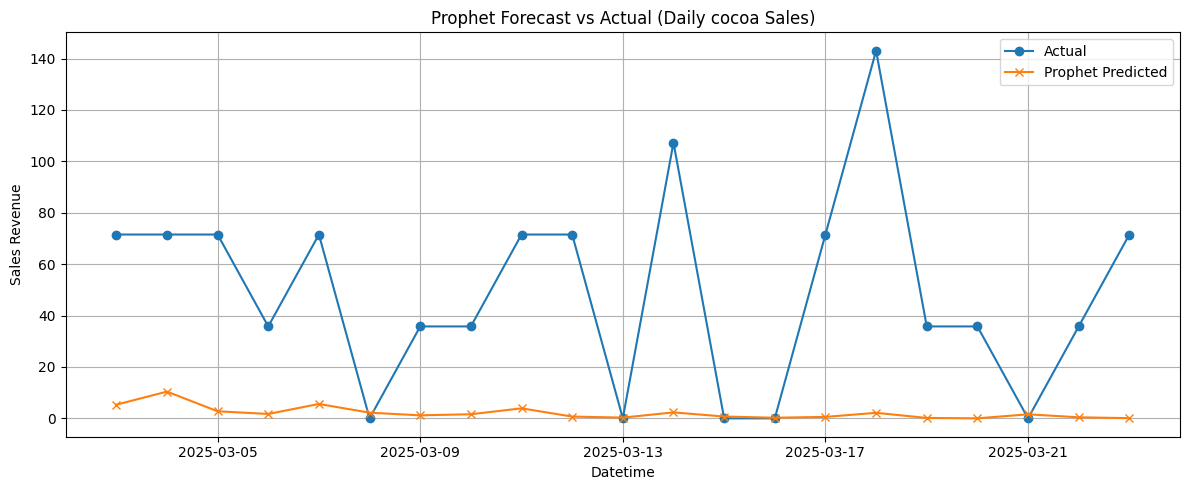

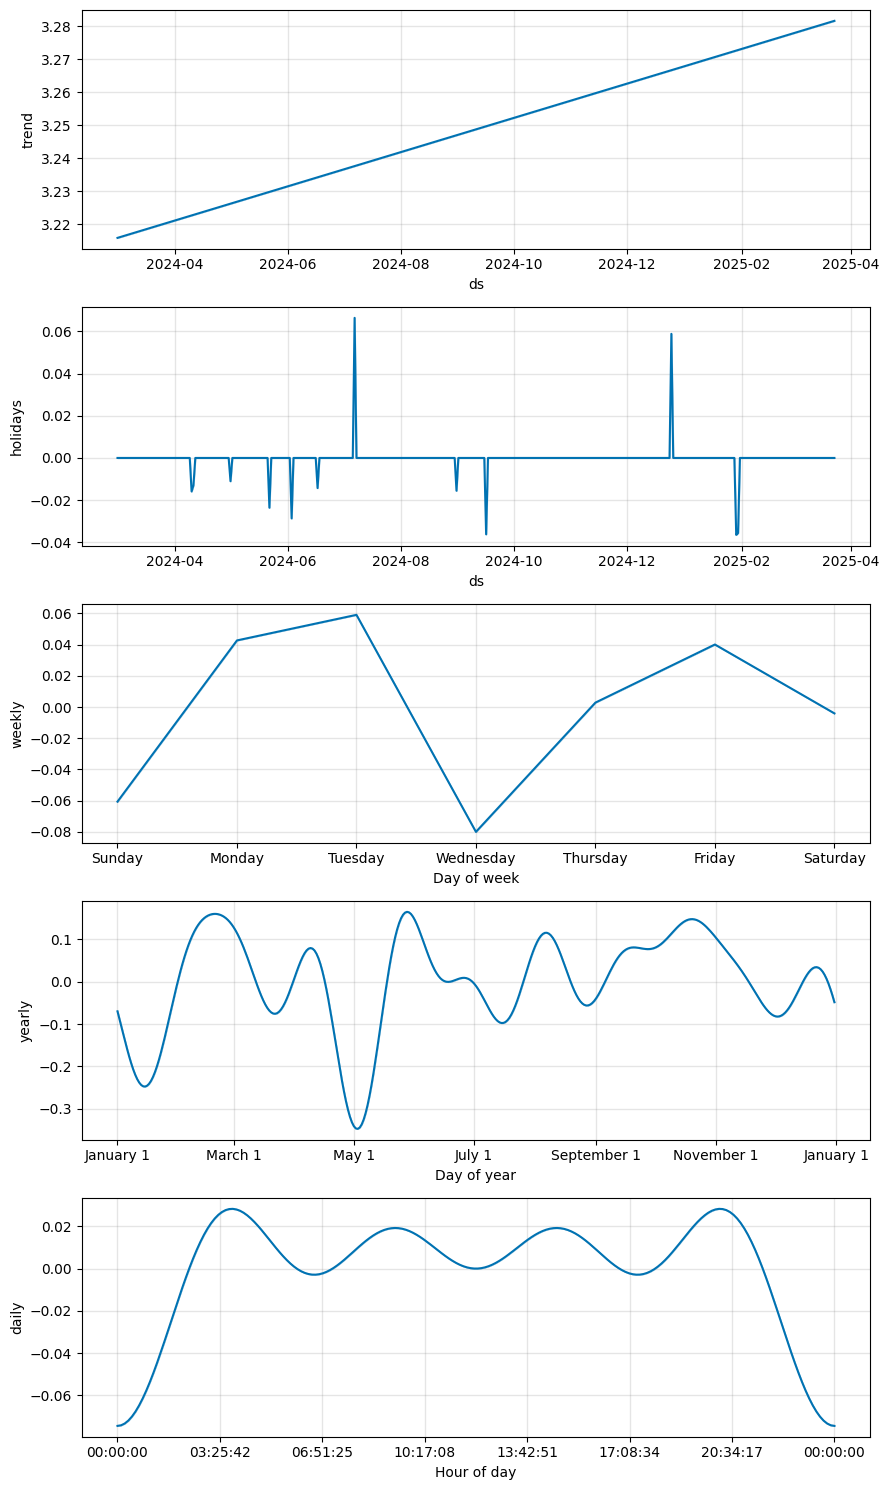

In [40]:
model_s('cocoa')

### Cortado

02:01:24 - cmdstanpy - INFO - Chain [1] start processing
02:01:24 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 13.26
Daily Prophet RMSE: 15.20
MAPE: 31.33%


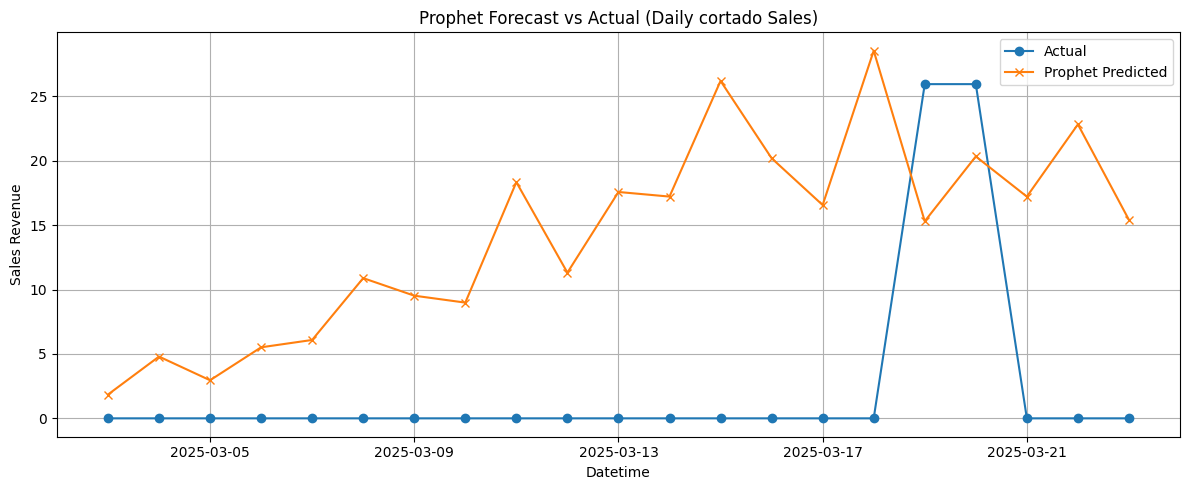

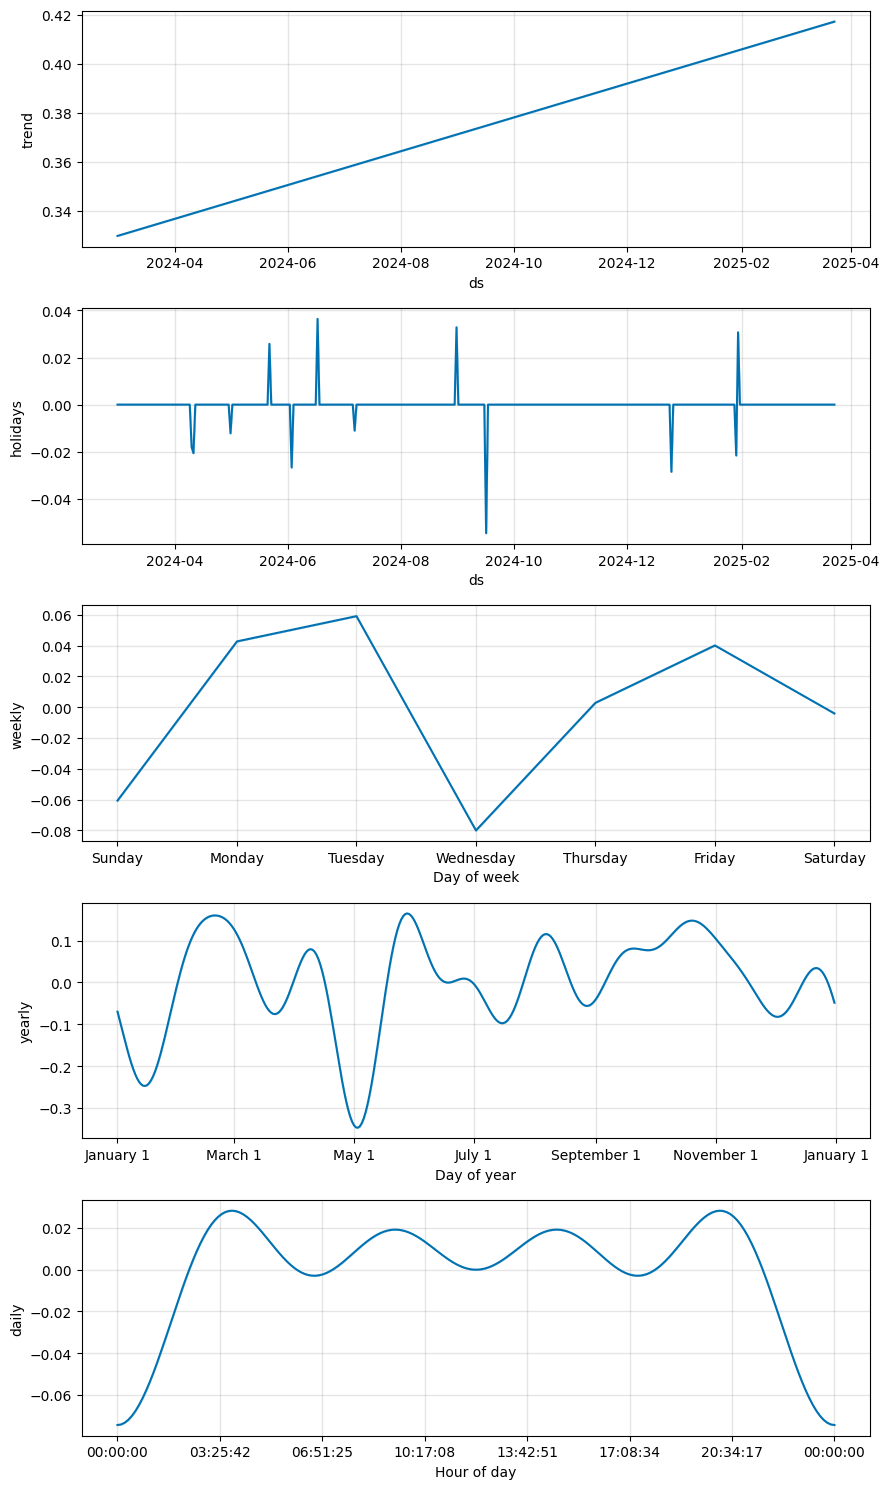

In [41]:
model_s('cortado')

### Espresso

02:01:46 - cmdstanpy - INFO - Chain [1] start processing
02:01:47 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 13.71
Daily Prophet RMSE: 18.93
MAPE: 92.04%


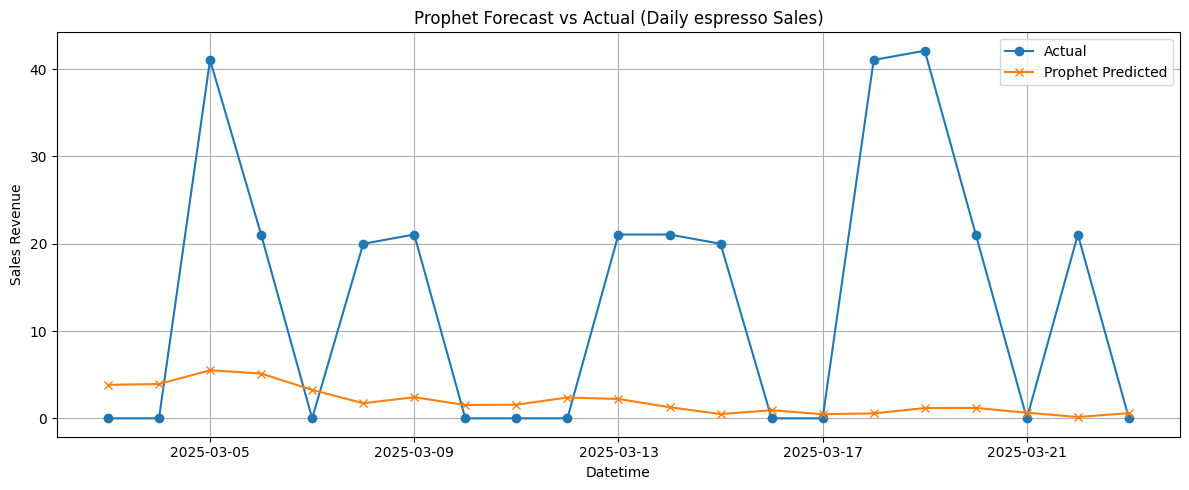

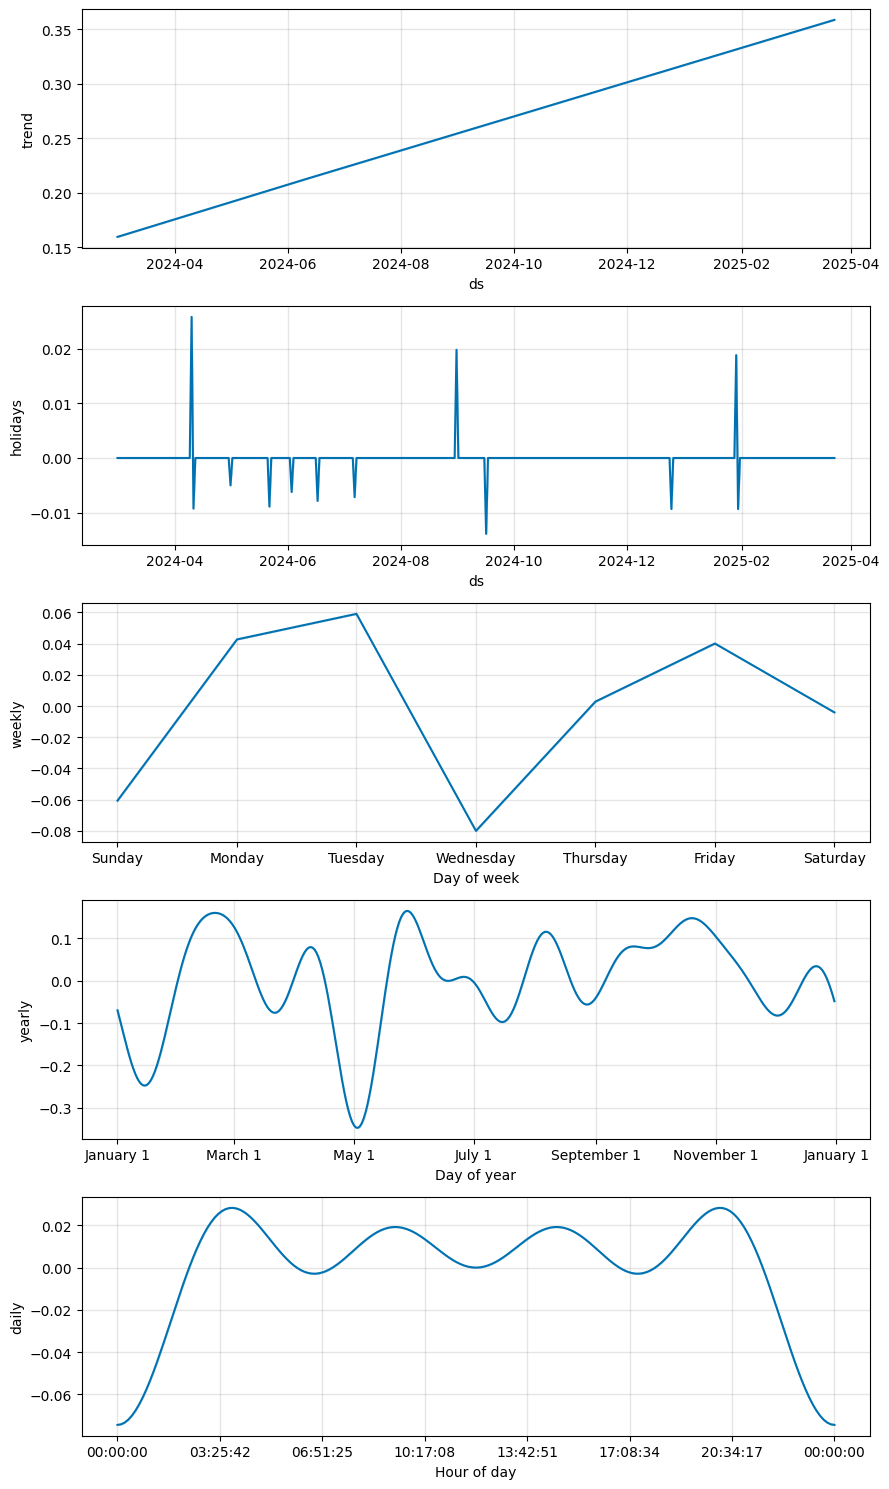

In [42]:
model_s('espresso')

### Hot Chocolate

02:02:12 - cmdstanpy - INFO - Chain [1] start processing
02:02:12 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 39.18
Daily Prophet RMSE: 59.94
MAPE: 100.00%


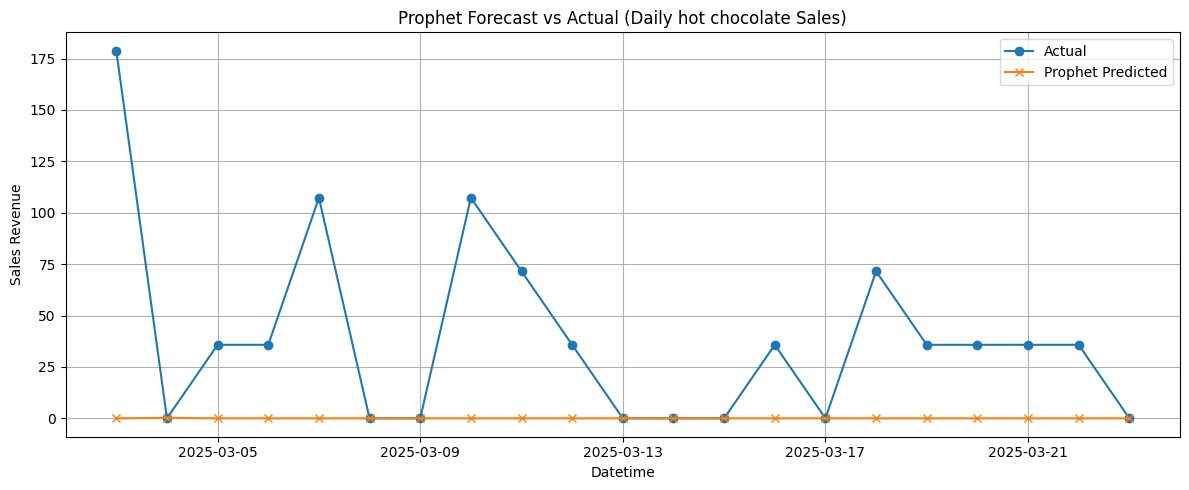

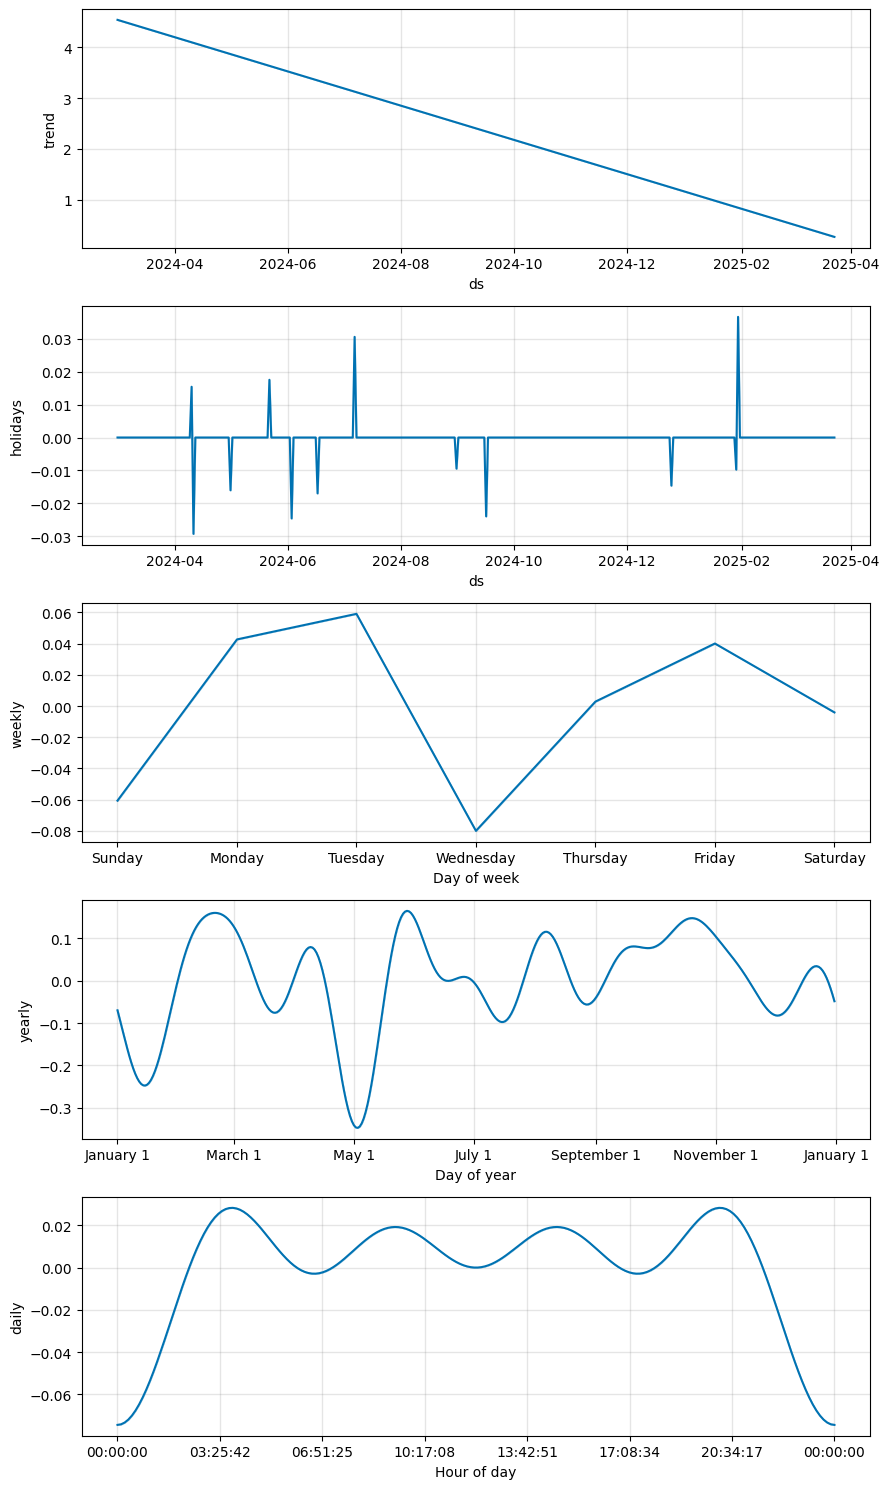

In [43]:
model_s('hot chocolate')

### Irish Whiskey

02:02:37 - cmdstanpy - INFO - Chain [1] start processing
02:02:37 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 18.82
Daily Prophet RMSE: 26.13
MAPE: 85.37%


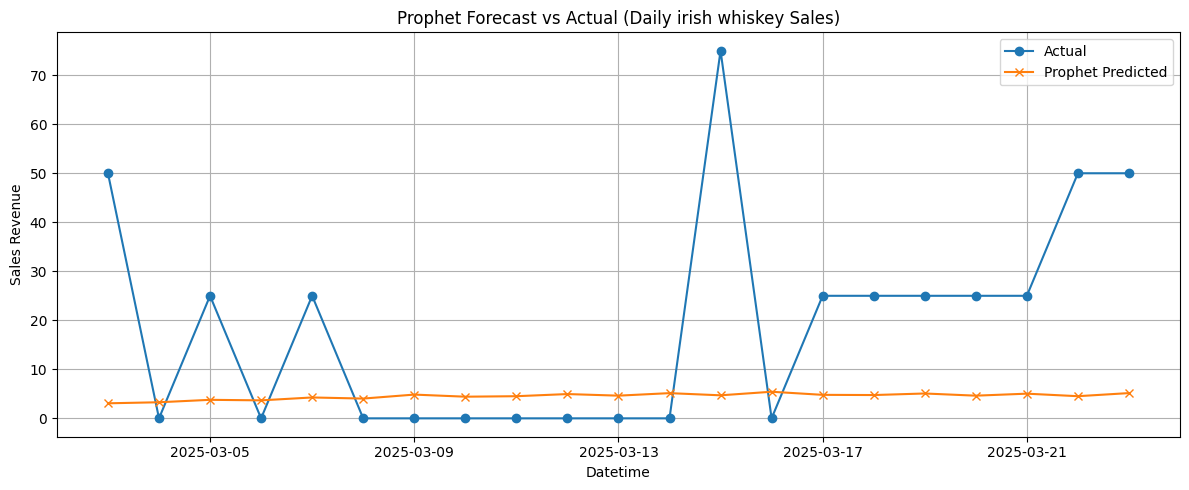

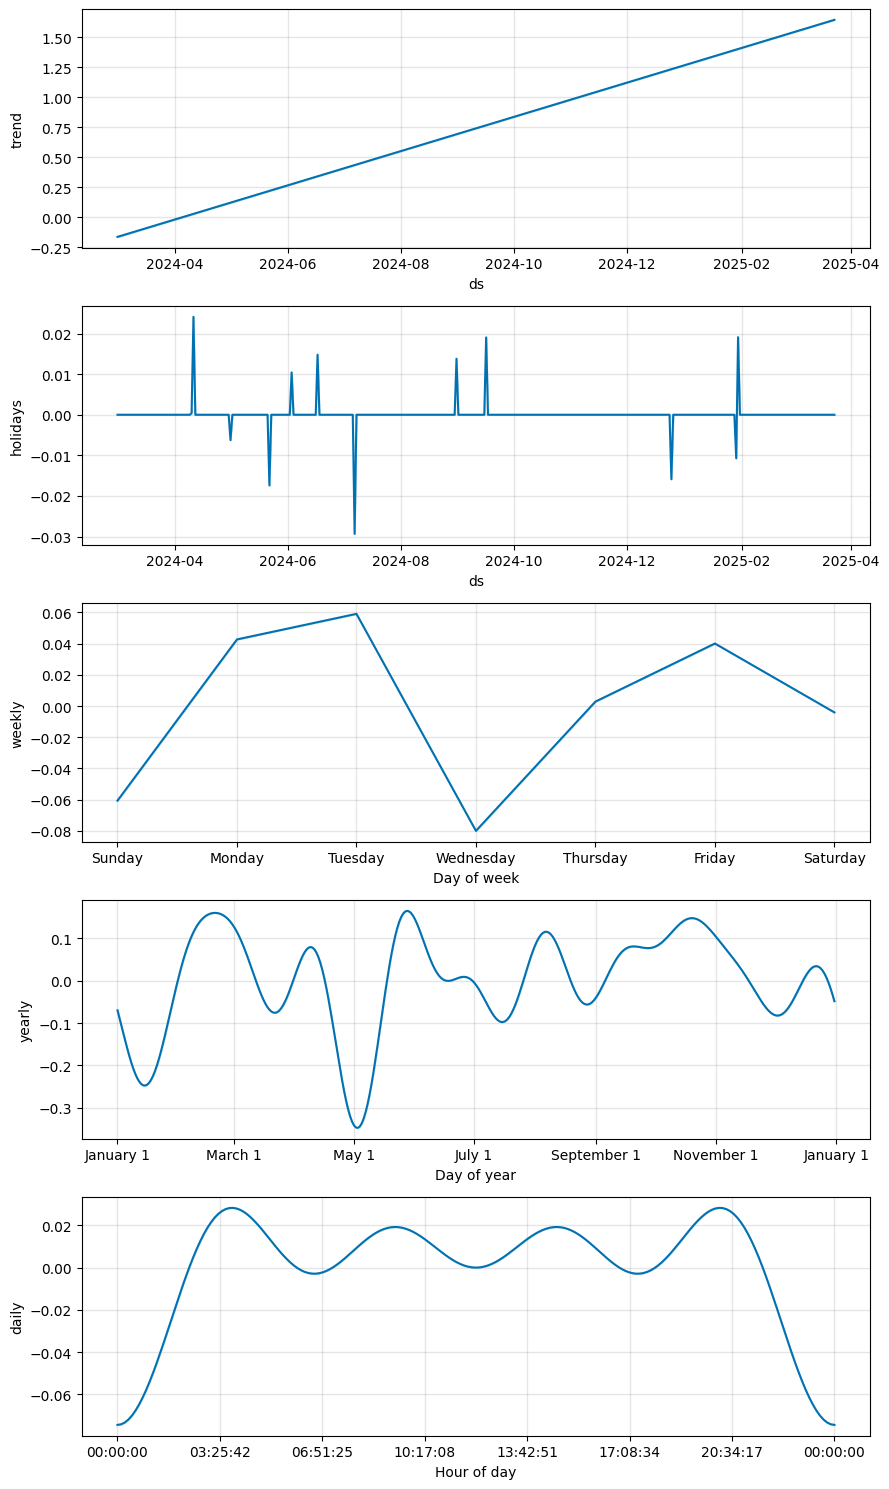

In [44]:
model_s('irish whiskey')

### Latte

02:02:58 - cmdstanpy - INFO - Chain [1] start processing
02:02:58 - cmdstanpy - INFO - Chain [1] done processing


Daily Prophet MAE: 79.75
Daily Prophet RMSE: 102.88
MAPE: 63.51%


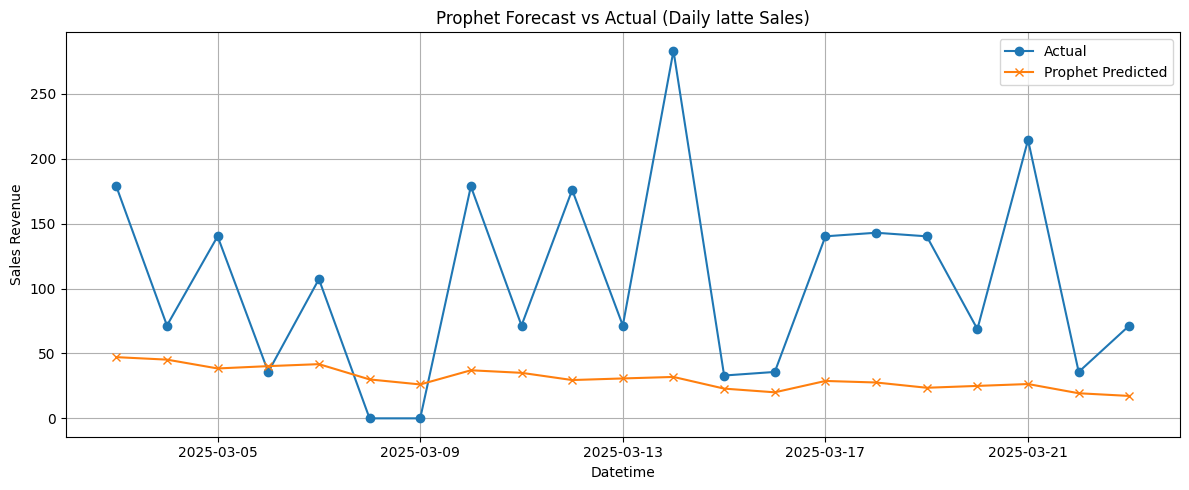

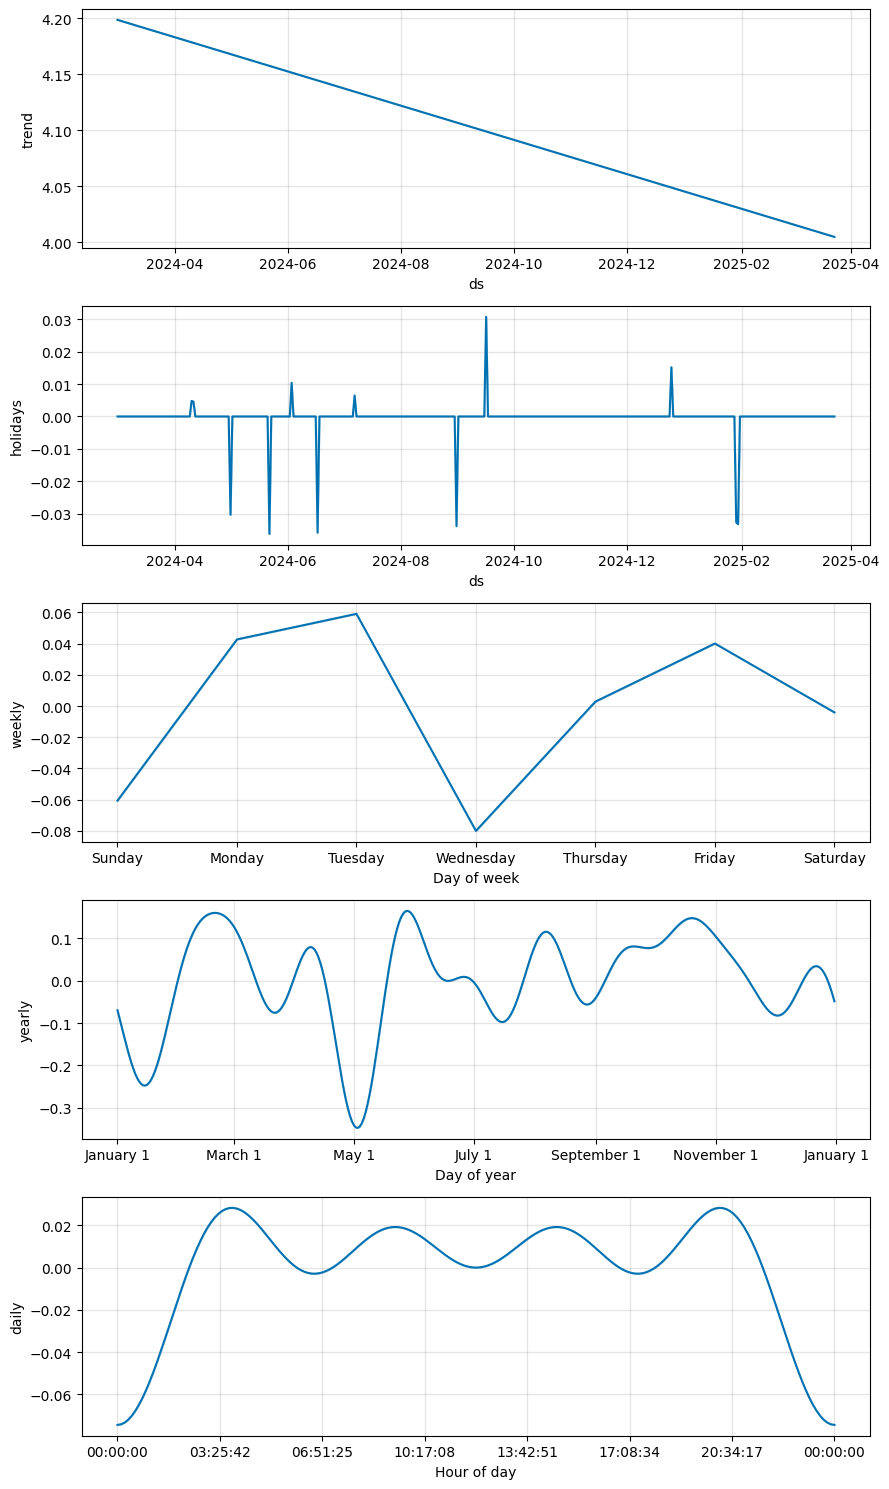

In [45]:
model_s('latte')